In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [195]:
!pip install tensorflow

In [196]:
import tensorflow as tf

In [197]:
!pip install keras

In [198]:
!pip install scikeras

In [199]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [200]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [201]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [202]:
!pip install shap
import shap

In [203]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [204]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [205]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [206]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [207]:
import sys
sys.path.append("./../../")
from gcp_env import PROJECT_ID, LOCATION

In [208]:
project_id = PROJECT_ID # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [209]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users_with_country"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [210]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [211]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [212]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [213]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  5000
Number of bots:  5000


In [214]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [215]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [216]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  5000
Number of human users:  5000


## Data preparation

In [217]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [218]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [219]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [220]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [221]:
column_to_remove

['withheld']

In [222]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [223]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


### Location mapping

#### Tried some supporting libs:
    - pycountry.countries.search_fuzzy: working not too good with some basic locations 
    - locationtagger: working not too good with some basic locations 
    - geograpy.get_place_context: chosen tool to map location to country
    
Chosen **geograpy3 lib** - mapping moved to preprocessing step - added new columns 'country' and 'country_numeric'

In [224]:
import json
 
with open('./../../data-preprocessing/scripts/users/countries_dict.json') as json_file:
    country_dict = json.load(json_file)

#### Null and NaN statistics

In [225]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 3476
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0
country: 0
country_numeric: 0


#### Extract some information from dataframe to new columns

##### Description length

In [226]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [227]:
from datetime import datetime

In [228]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [229]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [230]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description", 'country']
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_location  \
0     1428769922507751429      1         0          0             1   
1     1484544053572419585      0         0          0             1   
2      842202106324951040      1         0          0             1   
3     1447956502443069446      0         0          0             1   
4                21309002      1         0          0             1   
...                   ...    ...       ...        ...           ...   
9995           3275187061      0         0          0             1   
9996  1485289449487572996      1         0          0             0   
9997  1215382704876871680      0         0          0             1   
9998  1480725883820208131      1         0          0             0   
9999            407458156      0         0          0             1   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                         1                 0              2.0   
1                         1                 0              0.0   
2                         1                 0              3.0   
3                         1                 0              0.0   
4                         1                 0              3.0   
...                     ...               ...              ...   
9995                      1                 1            352.0   
9996                      1                 0              0.0   
9997                      1                 0            608.0   
9998                      1                 0              0.0   
9999                      1                 1            864.0   

      following_count  tweet_count  listed_count  has_description  \
0                41.0          1.0           0.0                1   
1                24.0          1.0           0.0                1   
2                22.0          4.0           0.0                0   
3                20.0          1.0           0.0                1   
4                42.0          2.0           0.0                0   
...               ...          ...           ...              ...   
9995            190.0       1094.0          18.0                1   
9996             34.0          0.0           0.0                1   
9997           1265.0       1095.0          11.0                1   
9998              5.0          0.0           0.0                0   
9999            346.0     153532.0          47.0                1   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   0.0                0.0                0.0            0.0   
1                   0.0                0.0                0.0            0.0   
2                   0.0                0.0                0.0            0.0   
3                   1.0                0.0                0.0            0.0   
4                   0.0                0.0                0.0            0.0   
...                 ...                ...                ...            ...   
9995                5.0                0.0                0.0            0.0   
9996                0.0                0.0                0.0            0.0   
9997                0.0                0.0                1.0            0.0   
9998                0.0                0.0                0.0            0.0   
9999                0.0                0.0                1.0            0.0   

      url_no_urls  country_numeric  descr_len  account_age  
0             1.0             81.0      160.0        208.0  
1             0.0            170.0       72.0         54.0  
2             0.0             16.0        0.0       1826.0  
3             0.0              1.0       85.0        155.0  
4             0.0             81.0        0.0       4773.0  
...           ...              ...        ...          ...  
9995          1.0             16.0      156.0       2440.0  
9996          0.0              1.0        5.0         52.0  
9997          1.0              1.0    

### Filter data, left column by feature importance based on SHAP results

In [231]:
shap_features = ['followers_count', 'tweet_count', 'following_count', 'account_age', 'descr_len', 'country_numeric']

In [232]:
users_reduced_df = users_df.copy()
users_reduced_df = users_df.filter(['label', 'id']+shap_features)
users_reduced_df

label                   id  followers_count  tweet_count  \
0         1  1428769922507751429              2.0          1.0   
1         0  1484544053572419585              0.0          1.0   
2         1   842202106324951040              3.0          4.0   
3         0  1447956502443069446              0.0          1.0   
4         1             21309002              3.0          2.0   
...     ...                  ...              ...          ...   
9995      0           3275187061            352.0       1094.0   
9996      1  1485289449487572996              0.0          0.0   
9997      0  1215382704876871680            608.0       1095.0   
9998      1  1480725883820208131              0.0          0.0   
9999      0            407458156            864.0     153532.0   

      following_count  account_age  descr_len  country_numeric  
0                41.0        208.0      160.0             81.0  
1                24.0         54.0       72.0            170.0  
2                22.0       1826.0        0.0             16.0  
3                20.0        155.0       85.0              1.0  
4                42.0       4773.0        0.0             81.0  
...               ...          ...        ...              ...  
9995            190.0       2440.0      156.0             16.0  
9996             34.0         52.0        5.0              1.0  
9997           1265.0        797.0      153.0              1.0  
9998              5.0         64.0        0.0              1.0  
9999            346.0       3781.0      135.0             41.0  

[10000 rows x 8 columns]

### Data type conversion (to float)

In [233]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [234]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [235]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [236]:
train_data.describe()

label            id  followers_count   tweet_count  \
count  7000.000000  7.000000e+03     7.000000e+03  7.000000e+03   
mean      0.503857  5.543646e+17     6.229971e+03  6.554910e+03   
std       0.500021  6.098100e+17     4.412925e+04  3.316229e+04   
min       0.000000  9.530000e+02     0.000000e+00  0.000000e+00   
25%       0.000000  2.792374e+08     3.300000e+01  2.200000e+01   
50%       1.000000  3.399836e+09     2.710000e+02  5.015000e+02   
75%       1.000000  1.207494e+18     1.565500e+03  3.310500e+03   
max       1.000000  1.495955e+18     1.730667e+06  1.184641e+06   

       following_count  account_age    descr_len  country_numeric  
count      7000.000000  7000.000000  7000.000000      7000.000000  
mean       1253.036286  2442.663000    84.592000        78.490000  
std        6121.951212  1640.465006    59.651674        95.261335  
min           0.000000    22.000000     0.000000         1.000000  
25%          74.000000   818.000000    23.000000         1.000000  
50%         269.000000  2407.000000    95.000000        18.000000  
75%         899.000000  3995.000000   143.000000       165.000000  
max      244195.000000  5724.000000   243.000000       250.000000

#### Describes training data for bots

In [237]:
train_data.loc[train_data['label']==1].describe()

label            id  followers_count    tweet_count  following_count  \
count  3527.0  3.527000e+03      3527.000000    3527.000000      3527.000000   
mean      1.0  6.799368e+17      2016.999716    2185.104338       770.499008   
std       0.0  6.153791e+17     19503.794857   11279.654017      4195.024713   
min       1.0  9.280410e+05         0.000000       0.000000         0.000000   
25%       1.0  8.678293e+08        14.000000       7.000000        41.000000   
50%       1.0  8.605276e+17        81.000000     127.000000       140.000000   
75%       1.0  1.285165e+18       410.000000    1086.000000       431.000000   
max       1.0  1.493160e+18    702018.000000  497641.000000    150720.000000   

       account_age    descr_len  country_numeric  
count  3527.000000  3527.000000      3527.000000  
mean   2060.185143    67.609300        64.706549  
std    1565.122289    62.244412        90.292452  
min      30.000000     0.000000         1.000000  
25%     604.000000     0.000000         1.000000  
50%    1776.000000    58.000000         1.000000  
75%    3446.500000   134.000000       106.000000  
max    5484.000000   243.000000       249.000000

#### Describes training data for humans

In [238]:
train_data.loc[train_data['label']==0].describe()

label            id  followers_count   tweet_count  following_count  \
count  3473.0  3.473000e+03     3.473000e+03  3.473000e+03      3473.000000   
mean      0.0  4.268398e+17     1.050845e+04  1.099266e+04      1743.076303   
std       0.0  5.768540e+17     5.918594e+04  4.526135e+04      7563.173323   
min       0.0  9.530000e+02     0.000000e+00  0.000000e+00         0.000000   
25%       0.0  1.374800e+08     1.570000e+02  1.700000e+02       159.000000   
50%       0.0  1.900708e+09     9.130000e+02  1.578000e+03       499.000000   
75%       0.0  1.017309e+18     3.610000e+03  6.601000e+03      1413.000000   
max       0.0  1.495955e+18     1.730667e+06  1.184641e+06    244195.000000   

       account_age    descr_len  country_numeric  
count  3473.000000  3473.000000      3473.000000  
mean   2831.087820   101.838756        92.487763  
std    1624.084521    51.457456        98.105472  
min      22.000000     0.000000         1.000000  
25%    1343.000000    63.000000         1.000000  
50%    3094.000000   115.000000        43.000000  
75%    4342.000000   149.000000       236.000000  
max    5724.000000   181.000000       250.000000

# Data analysis

In [239]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [240]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [241]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot  3527
1  Validation data    Bot   743
2        Test data    Bot   730
3    Training data  Human  3473
4  Validation data  Human   757
5        Test data  Human   770

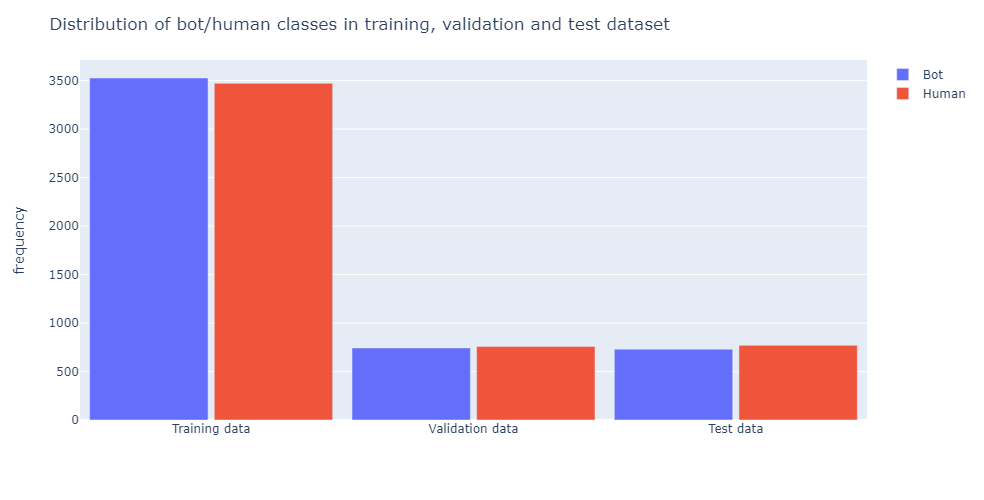

In [242]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### followers_count

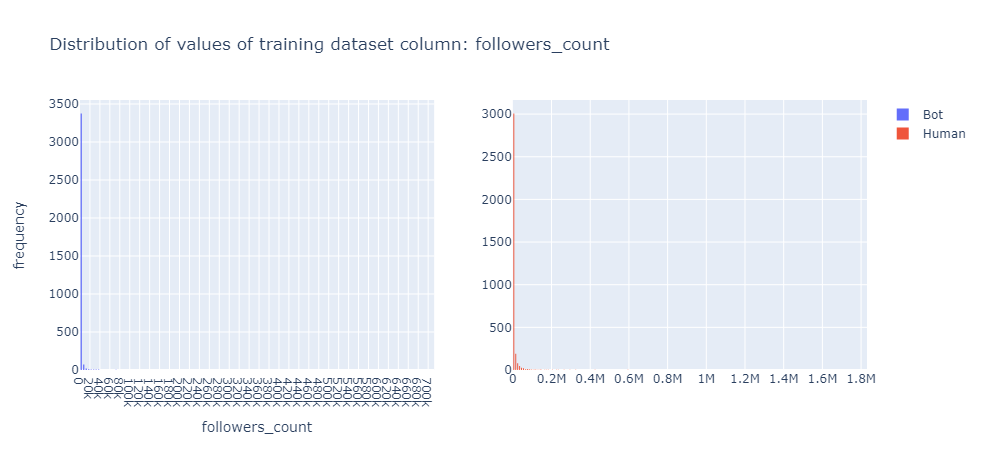

In [243]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000, range=[0, max(train_data.loc[train_data['label']==1,'followers_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=200000, range=[0, max(train_data.loc[train_data['label']==0,'followers_count'])+100000]),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  459


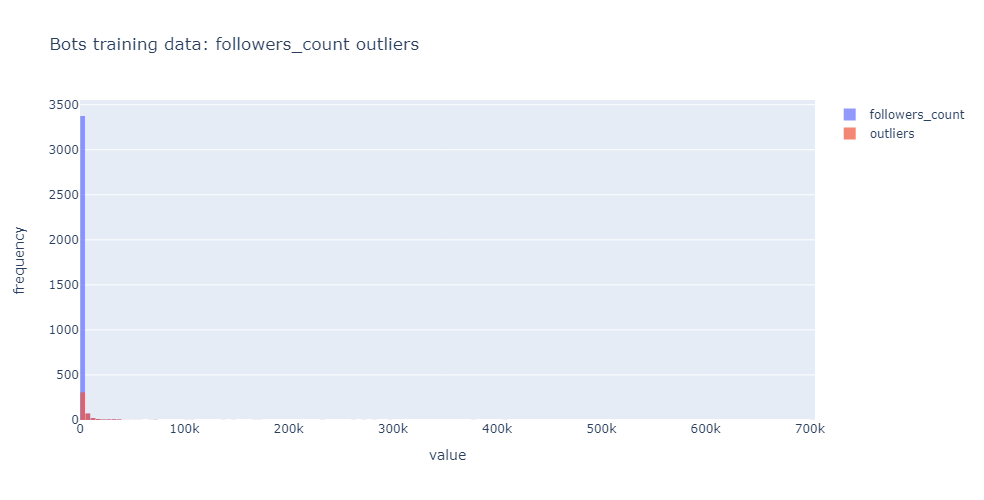

<Figure size 1500x700 with 0 Axes>

In [244]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  1088


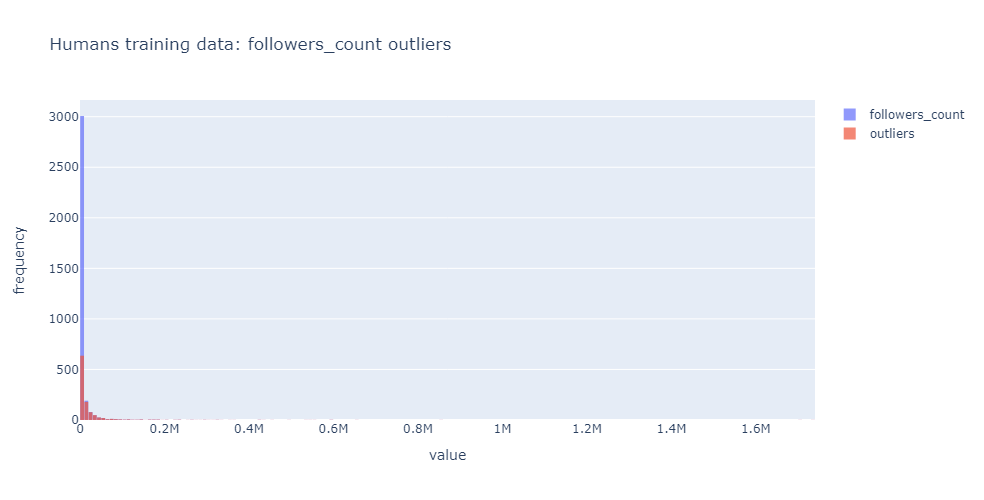

<Figure size 1500x700 with 0 Axes>

In [245]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [246]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [247]:
len(train_data[(train_data['label']==1)])

3527

In [248]:
len(train_data[(train_data['label']==0)])

3473

In [249]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [250]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [251]:
len(df_filtered_bots)

3443

In [252]:
len(df_filtered_humans)

3343

In [253]:
len(df_reduced_outliers_followers_count) 

6786

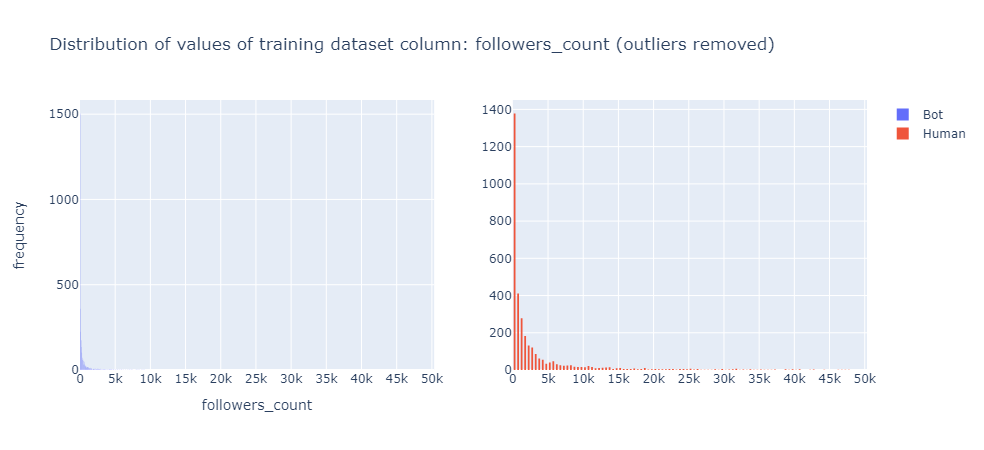

In [254]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    xaxis2=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

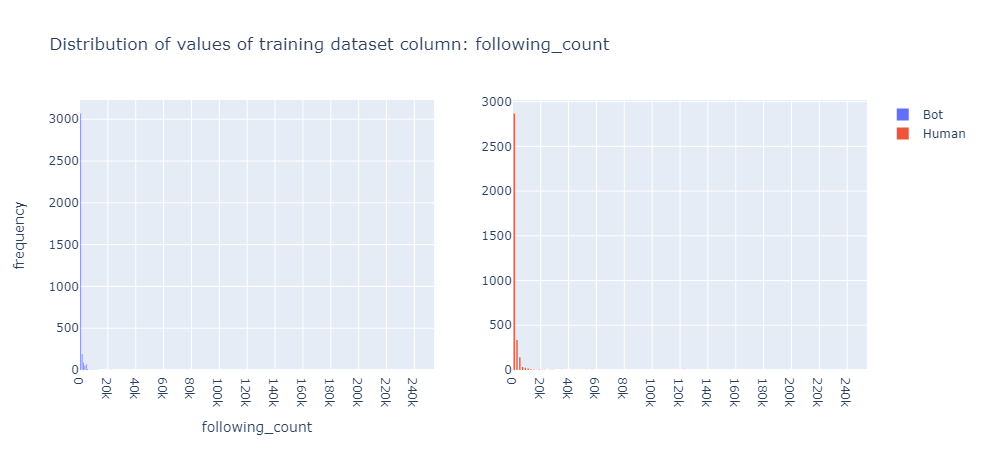

In [255]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [256]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

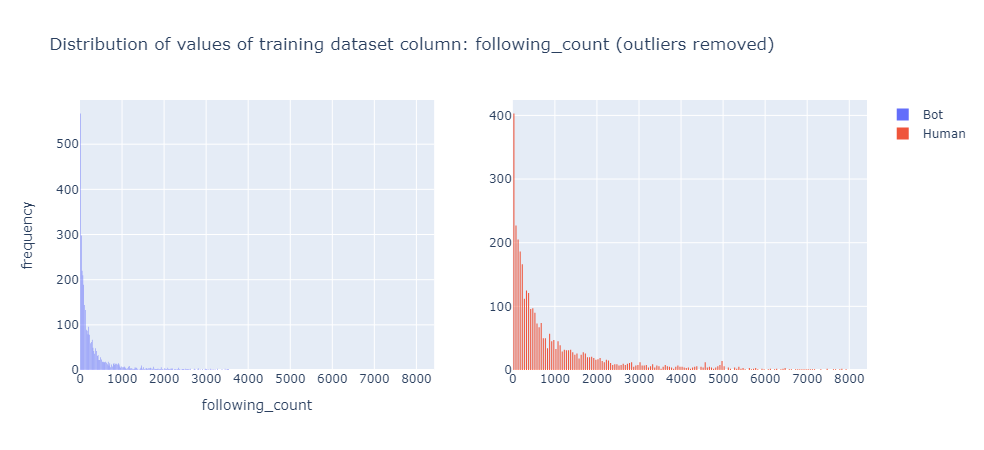

In [257]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

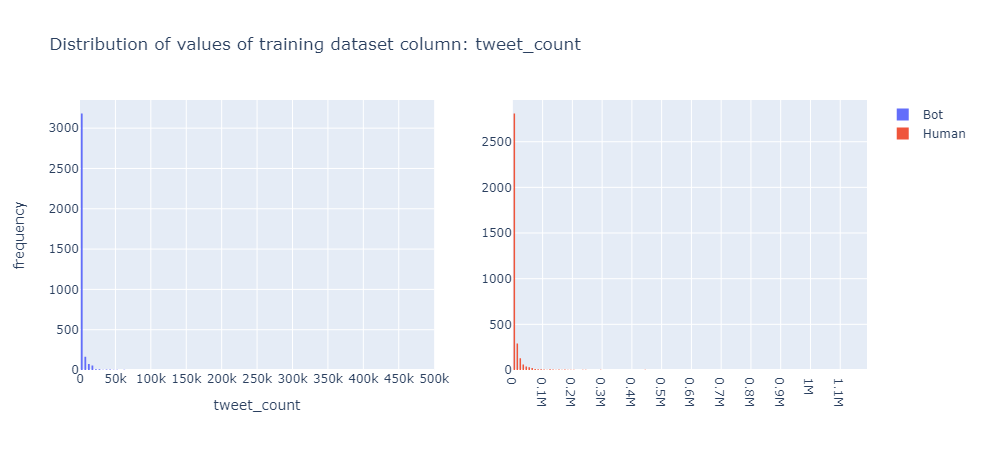

In [258]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=50000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [259]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

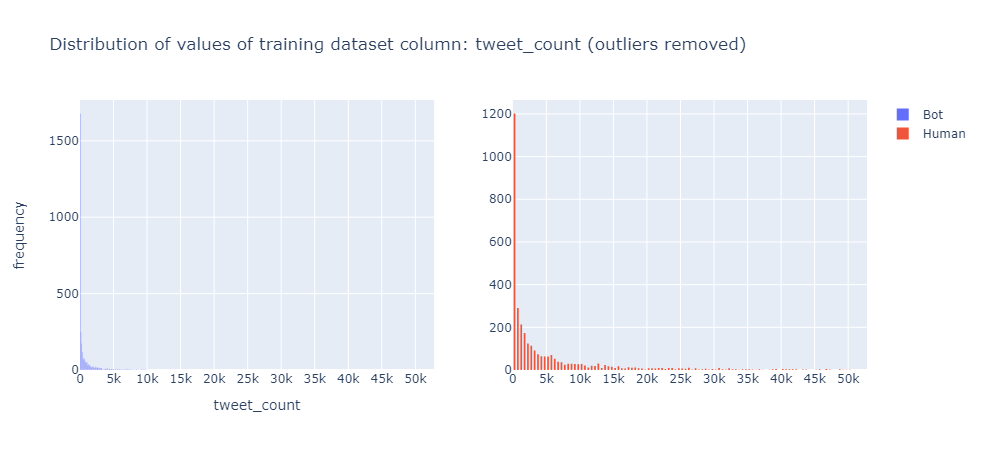

In [260]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+2500]),
    xaxis2=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+2500]),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

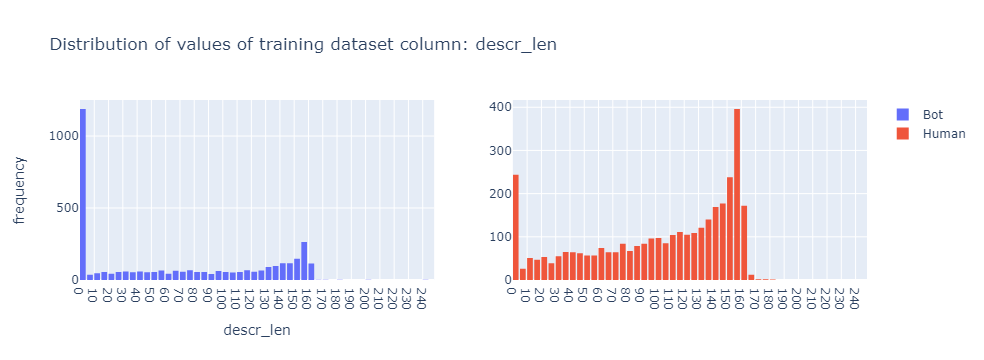

In [261]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10, range=[0, max(train_data['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=10, range=[0, max(train_data['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [262]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

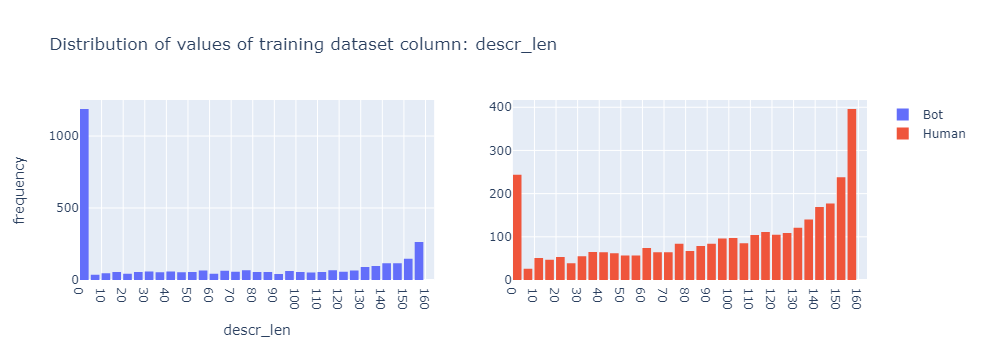

In [263]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10, range=[0, max(df_reduced_outliers_descr_len['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=10, range=[0, max(df_reduced_outliers_descr_len['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

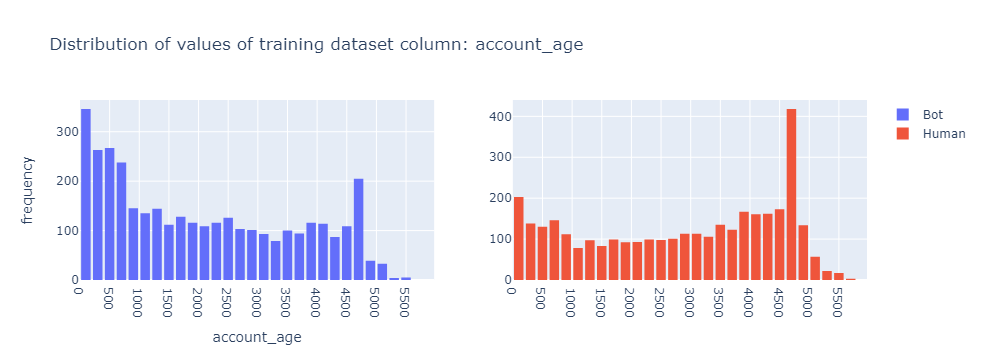

In [264]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [265]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

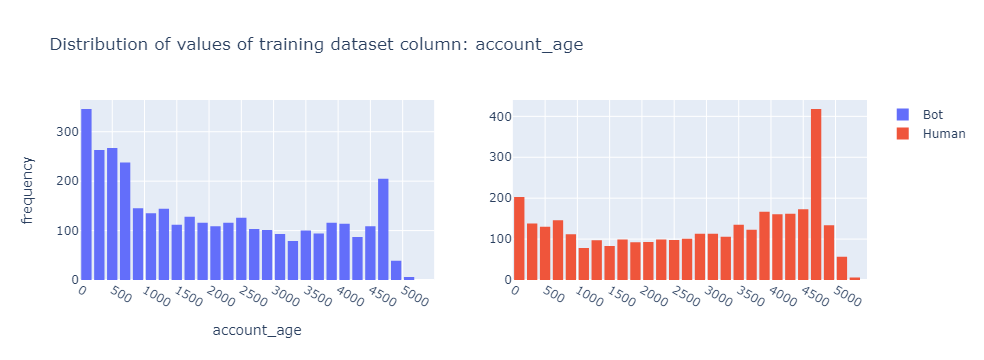

In [266]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

### country_numeric

In [267]:
def map_contries_to_str(numeric_encoded_country_list):
    mapped_countries = []
    for i,row in enumerate(numeric_encoded_country_list):
        numeric_value = int(row)
        res = dict((v,k) for k,v in country_dict.items())
        mapped_countries.append(res[numeric_value])
    return mapped_countries

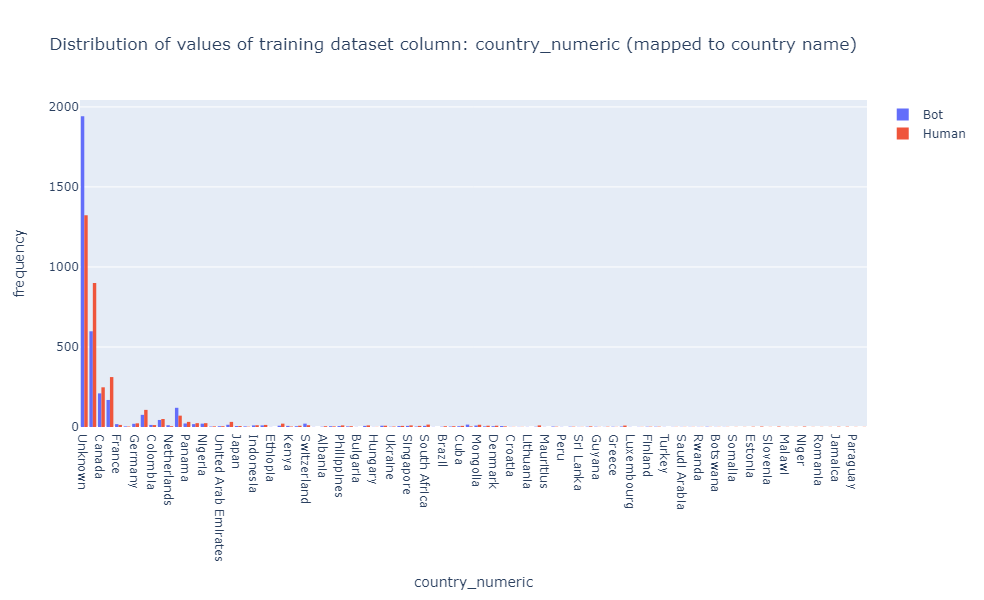

In [268]:
fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=map_contries_to_str(train_data.loc[train_data['label']==1,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
# row=1, col=1
)
fig.add_trace(go.Histogram(
    x=map_contries_to_str(train_data.loc[train_data['label']==0,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
# row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric (mapped to country name)',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1200,
    height=600,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10),
    # xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### country_numeric - outliers

In [269]:
df_reduced_outliers_country_numeric = df_99_percentile(df=train_data, column_name='country_numeric')

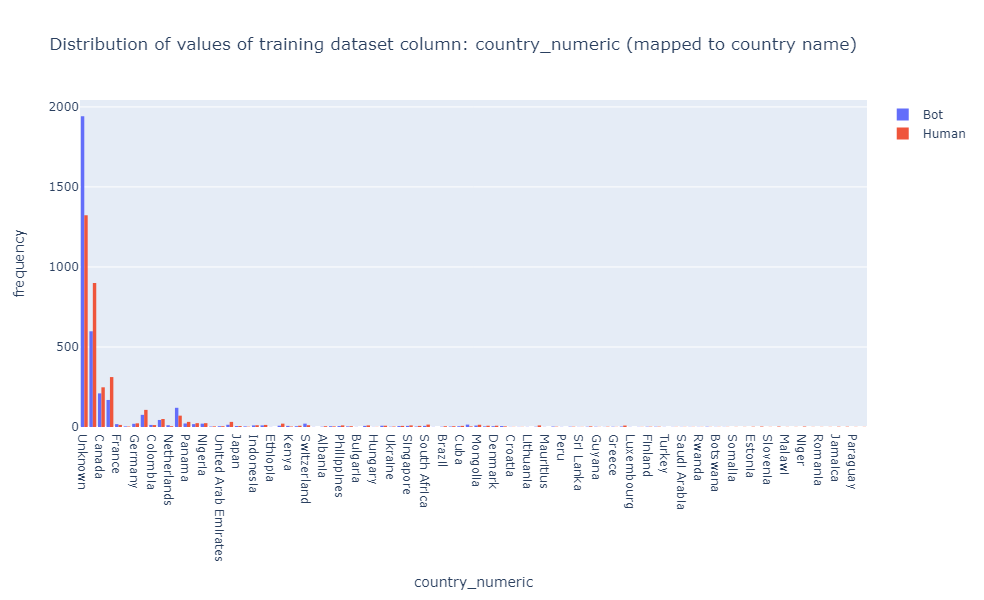

In [270]:
fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=map_contries_to_str(df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==1,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
# row=1, col=1
)
fig.add_trace(go.Histogram(
    x=map_contries_to_str(df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==0,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
# row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric (mapped to country name)',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1200,
    height=600,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10),
    # xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [271]:
# train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_tweet_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_listed_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_hashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# # train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_cashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_mentions, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_url_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_len, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_account_age, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_country_numeric, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [272]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age,
              df_reduced_outliers_country_numeric]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [273]:
len(train_data_wo_outliers)

6034

In [274]:
train_data_wo_outliers

label            id  followers_count  tweet_count  following_count  \
0       0.0  1.214019e+18            554.0        186.0            562.0   
1       0.0  1.099278e+08           2764.0       5129.0           1497.0   
2       1.0  1.362188e+18              0.0          1.0             54.0   
3       0.0  1.105811e+18            306.0       4613.0            163.0   
4       1.0  4.814260e+08             89.0          1.0            200.0   
...     ...           ...              ...          ...              ...   
6029    1.0  5.724116e+08             52.0          3.0            481.0   
6030    0.0  4.348814e+09             37.0         30.0            304.0   
6031    1.0  3.684963e+08             72.0         15.0             81.0   
6032    1.0  1.412609e+18             19.0        693.0            134.0   
6033    1.0  1.438696e+18              2.0        450.0              0.0   

      account_age  descr_len  country_numeric  
0           800.0      147.0             41.0  
1          4428.0      151.0              1.0  
2           392.0        0.0              1.0  
3          1099.0      144.0            236.0  
4          3695.0      129.0            236.0  
...           ...        ...              ...  
6029       3601.0        0.0              1.0  
6030       2296.0        0.0              1.0  
6031       3845.0      152.0            236.0  
6032        252.0       29.0              1.0  
6033        180.0       34.0            236.0  

[6034 rows x 8 columns]

#### Drop 'id' column

In [275]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [276]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  3473
Number of human users:  3473
Number of bots:  743
Number of human users:  743
Number of bots:  730
Number of human users:  730


In [277]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  2966
Number of human users:  2966
Number of bots:  743
Number of human users:  743
Number of bots:  730
Number of human users:  730


### Standardize data by column range of training set

In [278]:
def standardize_column(df, col_name, mean_training, std_training):
    df_cp = df.copy()
    df_cp[col_name] = (df[col_name] - mean_training) / std_training

    return df_cp

In [279]:
columns_to_standardize = ['followers_count', 'following_count', 'tweet_count', 'descr_len', 'account_age', 'country_numeric']

In [280]:
for column_name in columns_to_standardize:
    mean_training = train_data[column_name].mean()
    std_training = train_data[column_name].std()

    train_data = standardize_column(train_data, column_name, mean_training, std_training)
    val_data = standardize_column(val_data, column_name, mean_training, std_training)
    test_data = standardize_column(test_data, column_name, mean_training, std_training)

In [281]:
for column_name in columns_to_standardize:
    mean_training = train_data_wo_outliers[column_name].mean()
    std_training = train_data_wo_outliers[column_name].std()

    train_data_wo_outliers = standardize_column(train_data_wo_outliers, column_name, mean_training, std_training)
    val_data_wo_outliers = standardize_column(val_data_wo_outliers, column_name, mean_training, std_training)
    test_data_wo_outliers = standardize_column(test_data_wo_outliers, column_name, mean_training, std_training)

In [282]:
train_data

label  followers_count  tweet_count  following_count  account_age  \
6625    0.0        -0.128094    -0.192545        -0.113436    -1.001878   
2489    0.0        -0.078032    -0.044047         0.038726     1.209547   
9919    0.0        -0.092643    -0.120715         0.608965     0.315346   
6964    1.0        -0.140643    -0.198103        -0.196107    -1.250572   
3467    0.0        -0.133711    -0.059549        -0.178369    -0.819624   
...     ...              ...          ...              ...          ...   
3325    0.0        -0.128705    -0.129968         0.053210     0.557335   
1881    0.0        -0.116065    -0.046150         0.438414     1.001083   
4861    0.0        -0.140371    -0.198013        -0.189598     0.078234   
1175    0.0        -0.139805    -0.197232        -0.155423    -0.090000   
8447    0.0         3.903521    -0.173889        -0.135731    -0.494128   

      descr_len  country_numeric  
6625   1.043950        -0.394773  
2489   1.111053        -0.814401  
9919   1.262037         0.906075  
6964  -1.422111        -0.814401  
3467   0.993622         1.650915  
...         ...              ...  
3325   1.262037        -0.814401  
1881   1.060726        -0.814401  
4861  -0.616867         1.650915  
1175  -1.422111        -0.814401  
8447   0.909742         1.650915  

[6946 rows x 7 columns]

## Correlation

#### First drop columns in dataframes where there are same value in whole columns in trin dataset

In [283]:
same_data_columns = list(train_data.columns[train_data.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [284]:
train_data = train_data.drop(same_data_columns, axis=1)

val_data = val_data.drop(same_data_columns, axis=1)
test_data = test_data.drop(same_data_columns, axis=1)

In [290]:
sns.set(font_scale=3)

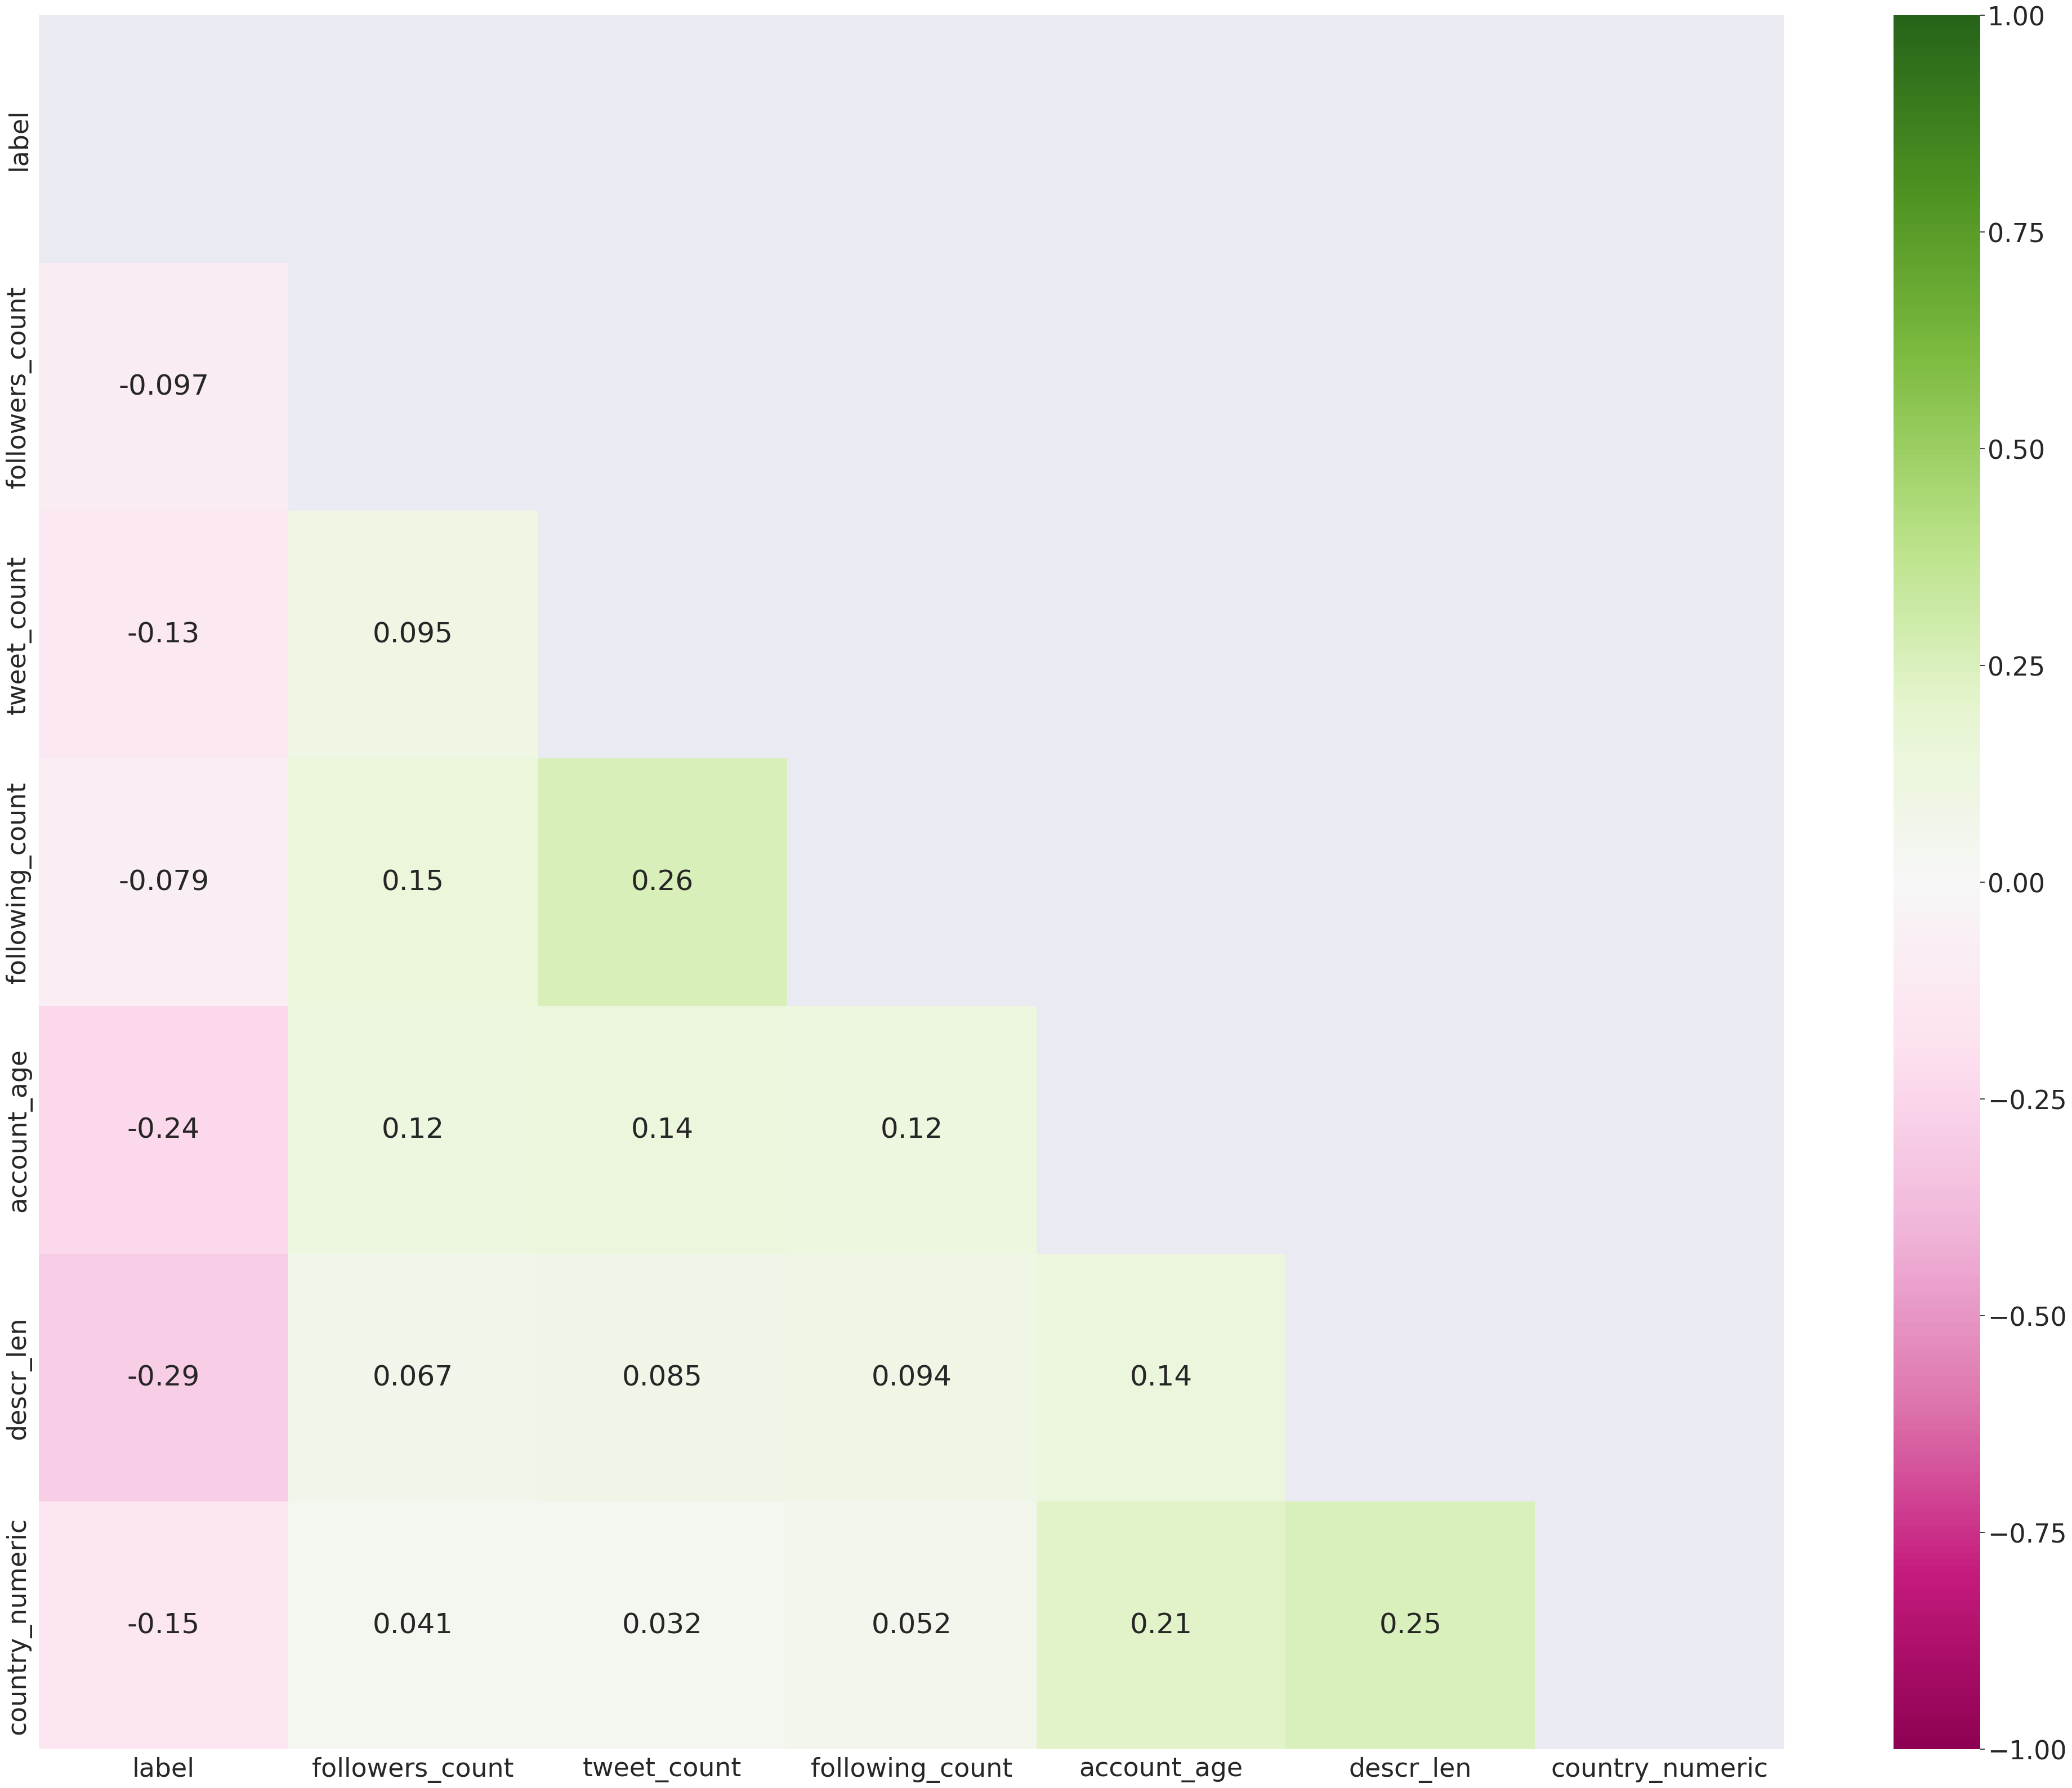

In [291]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [292]:
sns.set(font_scale=1)

In [293]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

In [294]:
train_data

label  followers_count  tweet_count  following_count  account_age  \
6625    0.0        -0.128094    -0.192545        -0.113436    -1.001878   
2489    0.0        -0.078032    -0.044047         0.038726     1.209547   
9919    0.0        -0.092643    -0.120715         0.608965     0.315346   
6964    1.0        -0.140643    -0.198103        -0.196107    -1.250572   
3467    0.0        -0.133711    -0.059549        -0.178369    -0.819624   
...     ...              ...          ...              ...          ...   
3325    0.0        -0.128705    -0.129968         0.053210     0.557335   
1881    0.0        -0.116065    -0.046150         0.438414     1.001083   
4861    0.0        -0.140371    -0.198013        -0.189598     0.078234   
1175    0.0        -0.139805    -0.197232        -0.155423    -0.090000   
8447    0.0         3.903521    -0.173889        -0.135731    -0.494128   

      descr_len  country_numeric  
6625   1.043950        -0.394773  
2489   1.111053        -0.814401  
9919   1.262037         0.906075  
6964  -1.422111        -0.814401  
3467   0.993622         1.650915  
...         ...              ...  
3325   1.262037        -0.814401  
1881   1.060726        -0.814401  
4861  -0.616867         1.650915  
1175  -1.422111        -0.814401  
8447   0.909742         1.650915  

[6946 rows x 7 columns]

In [295]:
# train_data = train_data.drop(['listed_count'], axis=1)
# val_data = val_data.drop(['listed_count'], axis=1)
# test_data = test_data.drop(['listed_count'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [296]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [297]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [298]:
sns.set(font_scale=3)

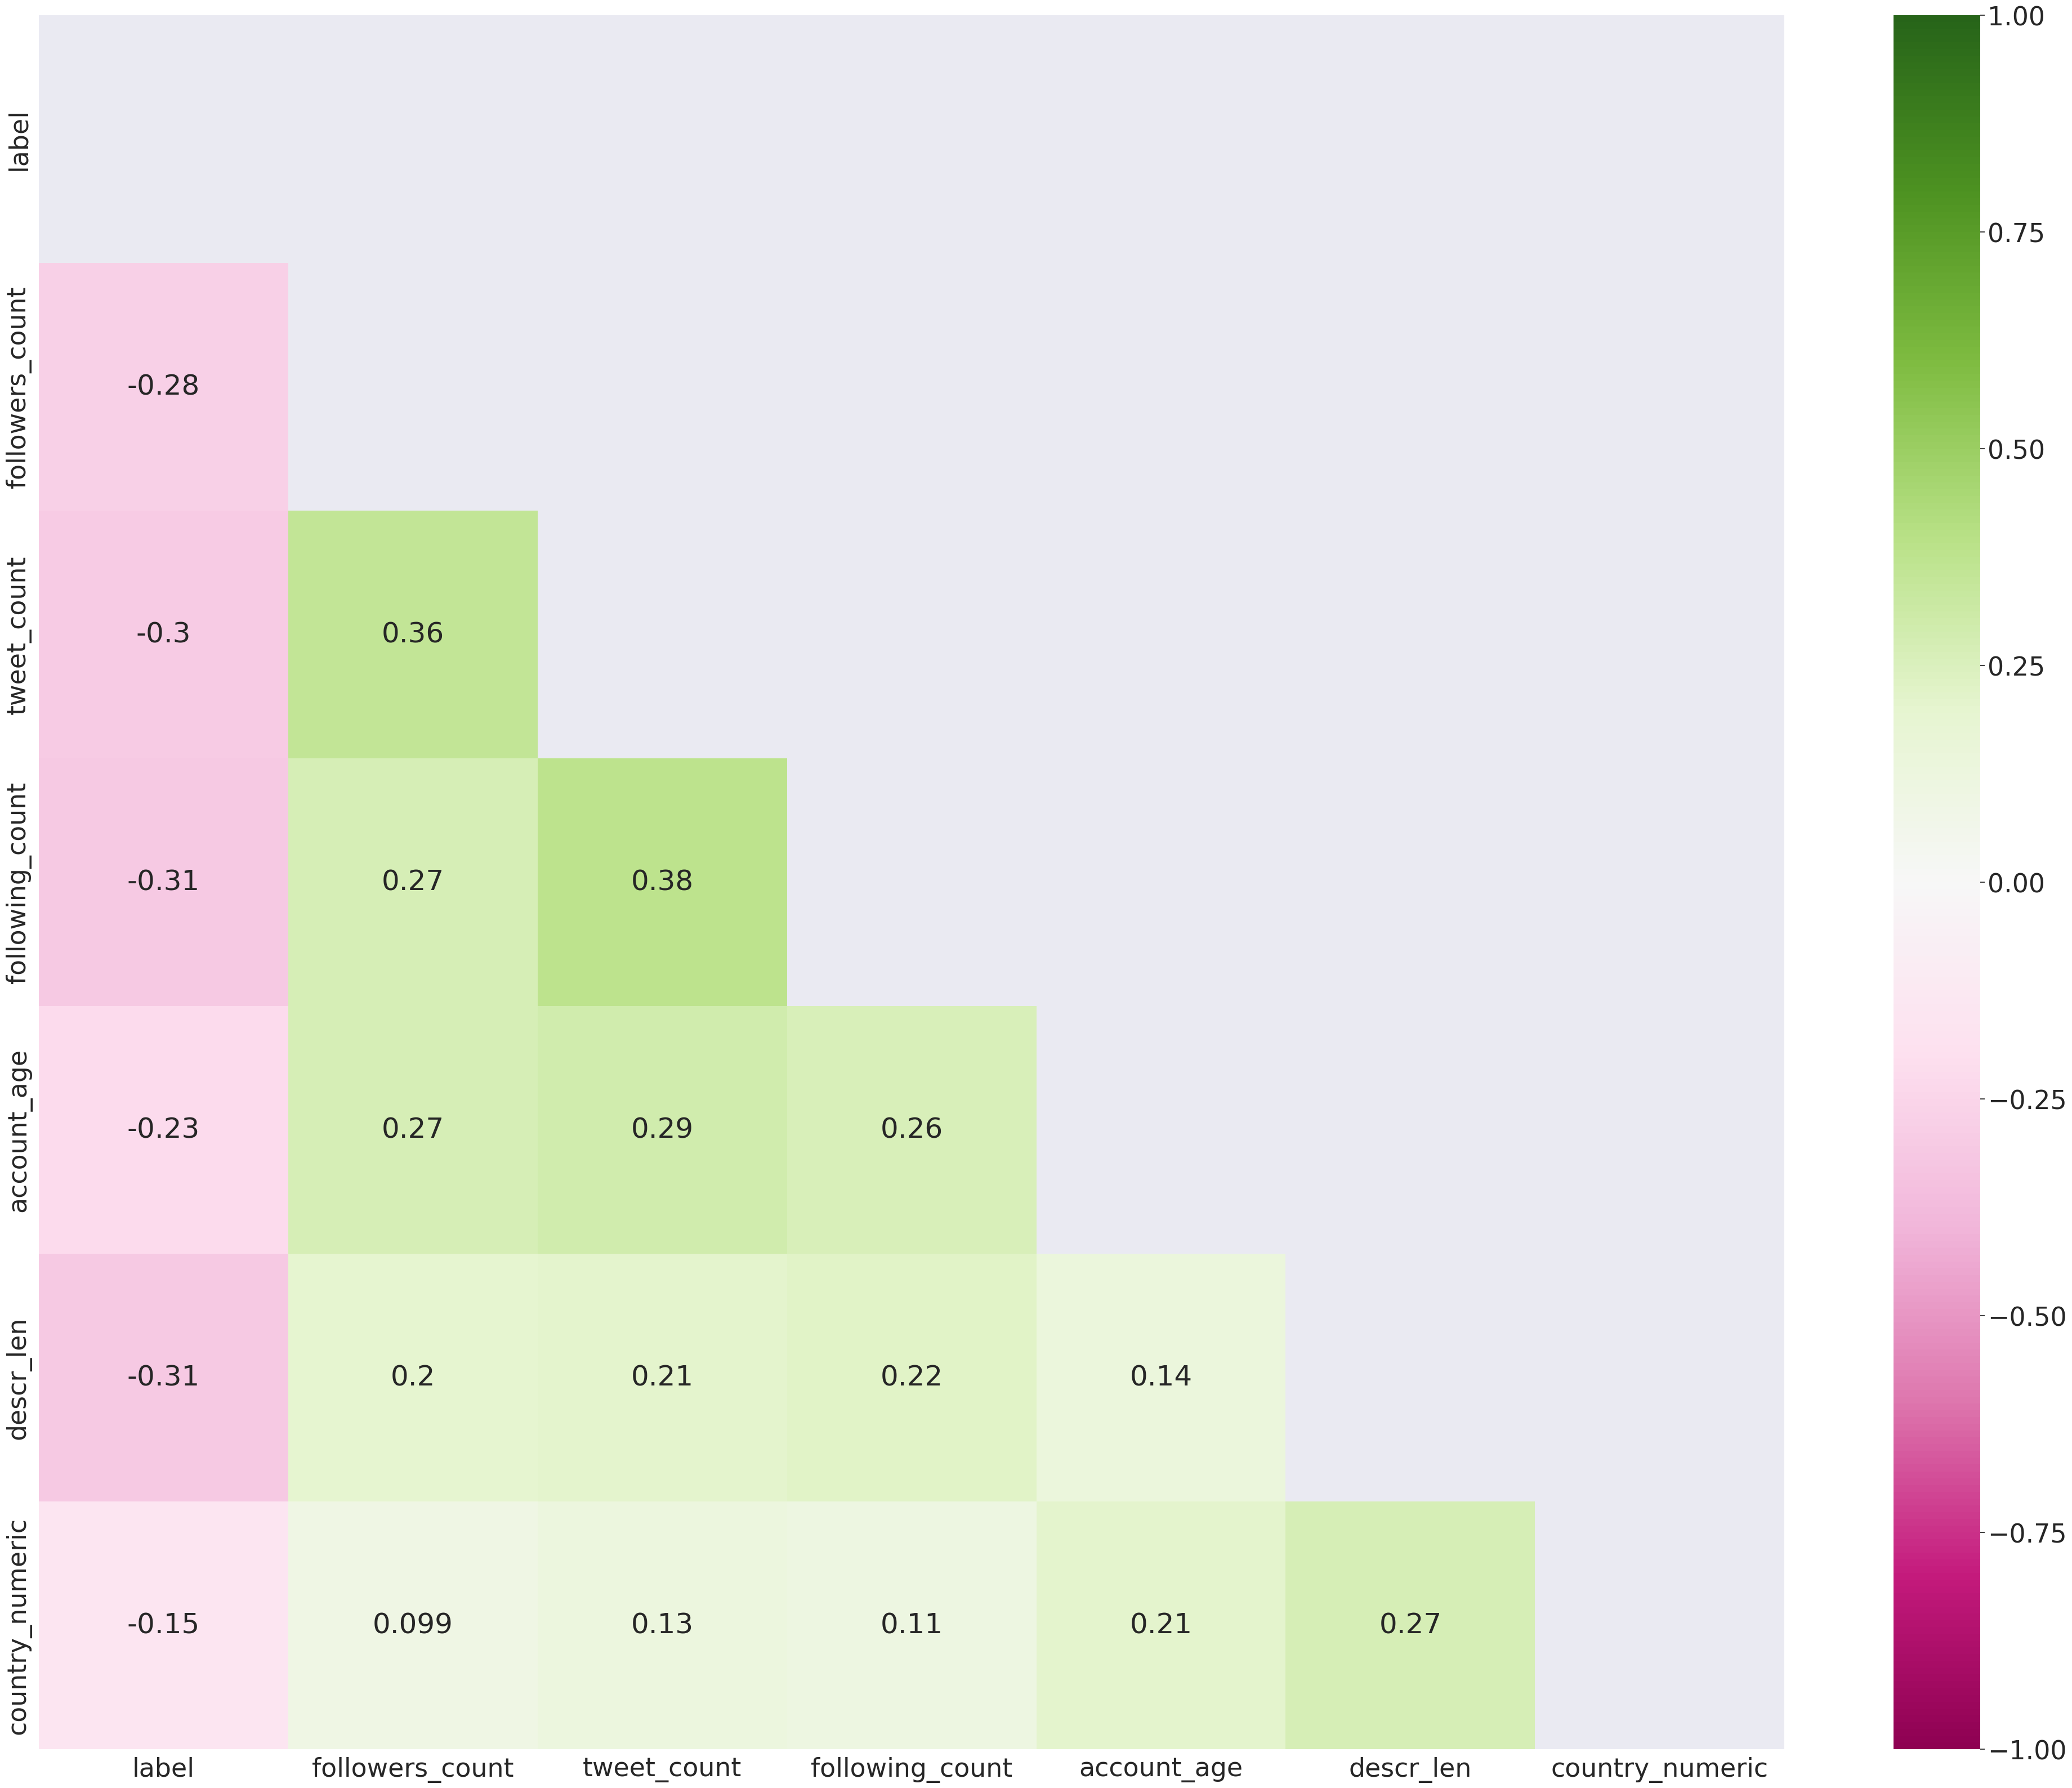

In [299]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [300]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [301]:
high_corr2

[]

In [302]:
# train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location', 'url_no_urls'], axis=1)
# val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location', 'url_no_urls'], axis=1)
# test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location', 'url_no_urls'], axis=1)

#### Split data for input and output

In [303]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [304]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [305]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [306]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [307]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [308]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [309]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-27 01:17:07.640707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-27 01:17:07.640789: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-27 01:17:07.640834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a211a560f591): /proc/driver/nvidia/version does not exist
2023-08-27 01:17:07.644489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### batch_size=10, epochs=300

#### Create and train model

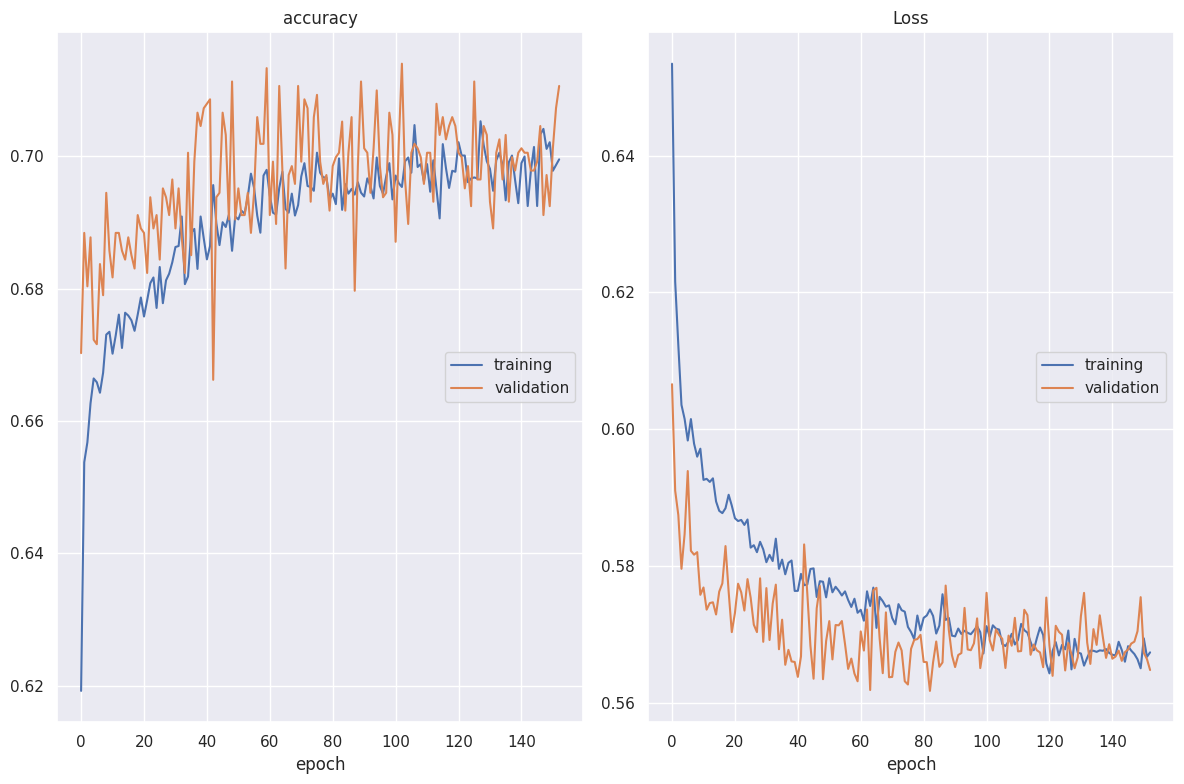

accuracy
	training         	 (min:    0.619, max:    0.705, cur:    0.700)
	validation       	 (min:    0.666, max:    0.714, cur:    0.711)
Loss
	training         	 (min:    0.564, max:    0.653, cur:    0.567)
	validation       	 (min:    0.562, max:    0.607, cur:    0.565)

Epoch 153: val_accuracy did not improve from 0.71400
695/695 [==============================] - 3s 4ms/step - loss: 0.5674 - accuracy: 0.6995 - val_loss: 0.5648 - val_accuracy: 0.7106


In [310]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_10_only_import_feat_standard'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.7061643835616438
Precision: [0.73047473 0.68649318]
Recall: 0.7589041095890411
F1 score: 0.720885
ROC AUC: 0.706164


(0.7061643835616438,
 array([0.73047473, 0.68649318]),
 0.7589041095890411,
 0.7208848405985686,
 0.7061643835616439)

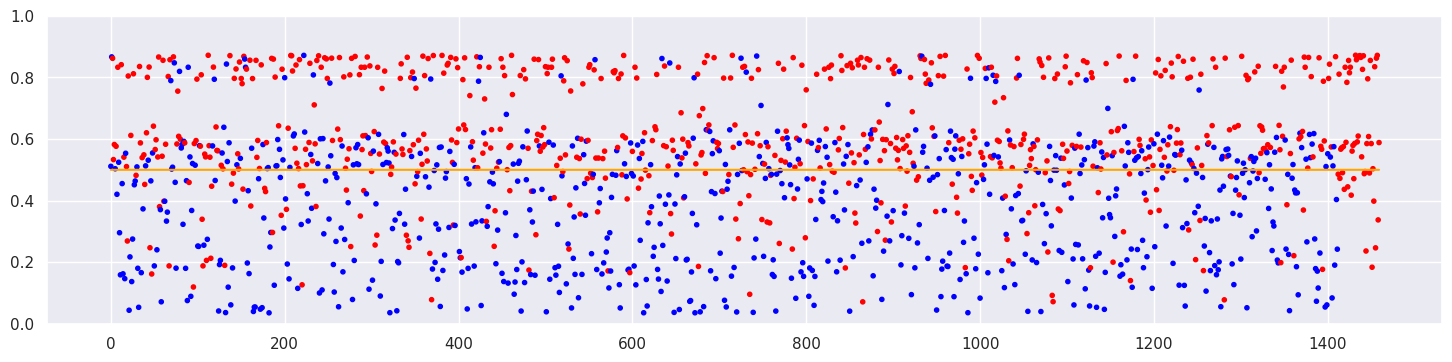

<Figure size 640x480 with 0 Axes>

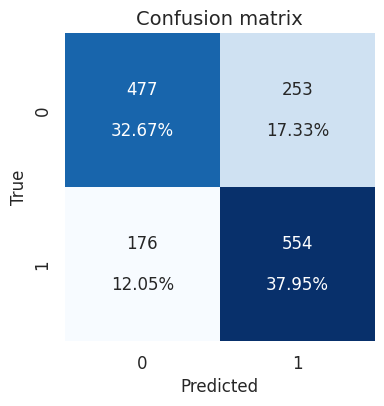

In [311]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=300

In [312]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                224       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

### Train model

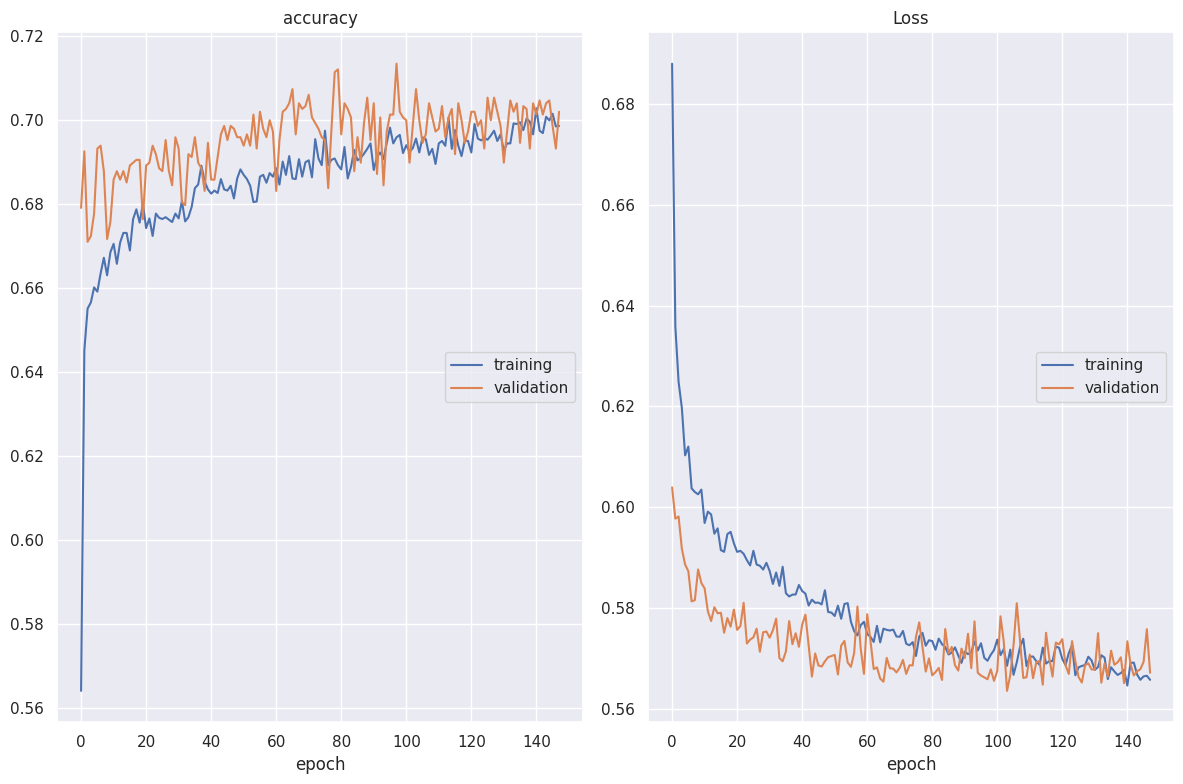

accuracy
	training         	 (min:    0.564, max:    0.703, cur:    0.699)
	validation       	 (min:    0.671, max:    0.713, cur:    0.702)
Loss
	training         	 (min:    0.565, max:    0.688, cur:    0.566)
	validation       	 (min:    0.564, max:    0.604, cur:    0.567)

Epoch 148: val_accuracy did not improve from 0.71332
139/139 [==============================] - 1s 8ms/step - loss: 0.5657 - accuracy: 0.6985 - val_loss: 0.5671 - val_accuracy: 0.7019


In [313]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_50_only_import_feat_standard'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=300)

In [314]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [315]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

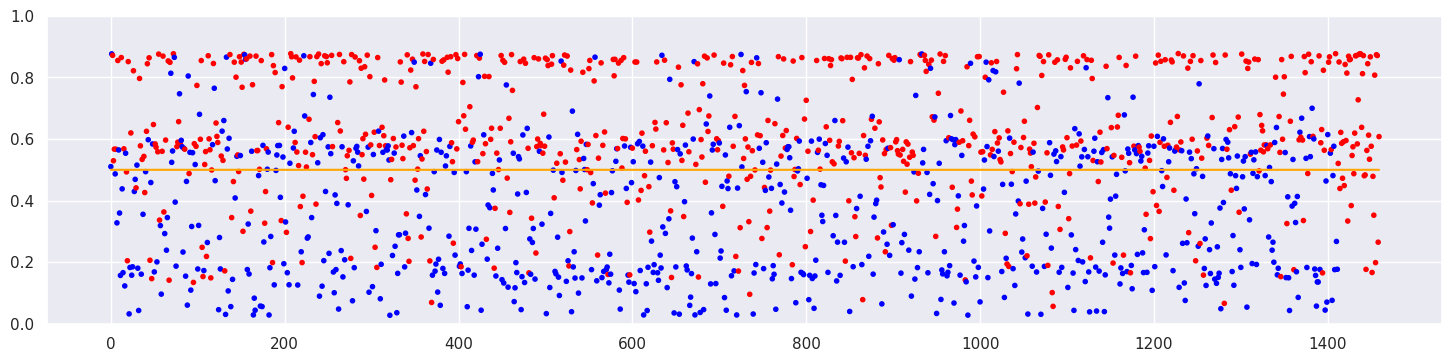

In [316]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.7047945205479452
Precision: [0.72754947 0.68617684]
Recall: 0.7547945205479452
F1 score: 0.718852
ROC AUC: 0.704795


(0.7047945205479452,
 array([0.72754947, 0.68617684]),
 0.7547945205479452,
 0.7188519243313763,
 0.7047945205479451)

<Figure size 640x480 with 0 Axes>

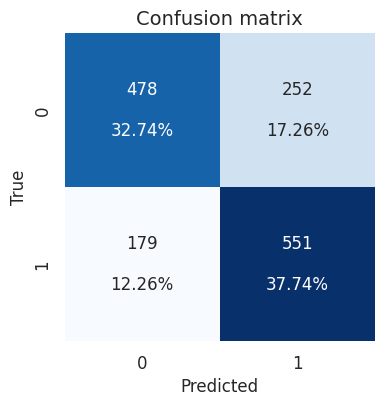

In [317]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=300

#### Create and train model

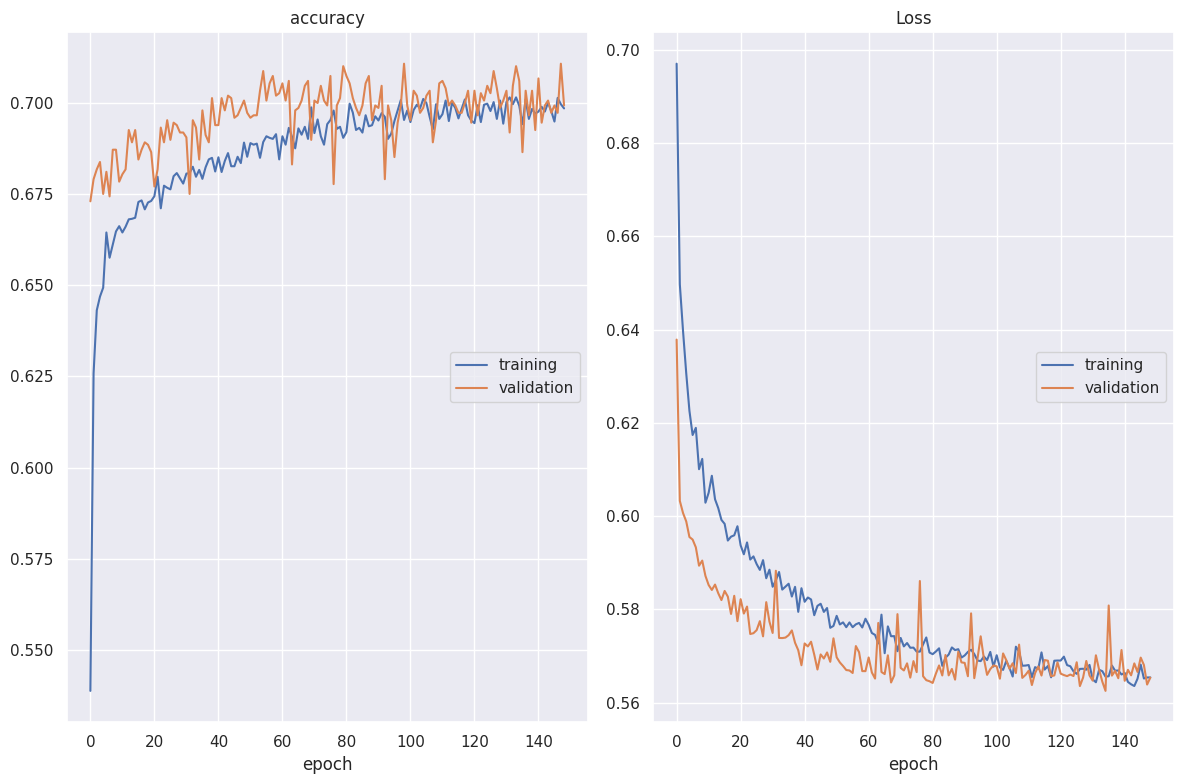

accuracy
	training         	 (min:    0.539, max:    0.701, cur:    0.698)
	validation       	 (min:    0.673, max:    0.711, cur:    0.699)
Loss
	training         	 (min:    0.564, max:    0.697, cur:    0.565)
	validation       	 (min:    0.563, max:    0.638, cur:    0.565)

Epoch 149: val_accuracy did not improve from 0.71063
70/70 [==============================] - 1s 13ms/step - loss: 0.5654 - accuracy: 0.6984 - val_loss: 0.5654 - val_accuracy: 0.6992


In [318]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_100_only_import_feat_standard'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.708904109589041
Precision: [0.70976616 0.70804911]
Recall: 0.7109589041095891
F1 score: 0.709501
ROC AUC: 0.708904


(0.708904109589041,
 array([0.70976616, 0.70804911]),
 0.7109589041095891,
 0.709501025290499,
 0.7089041095890412)

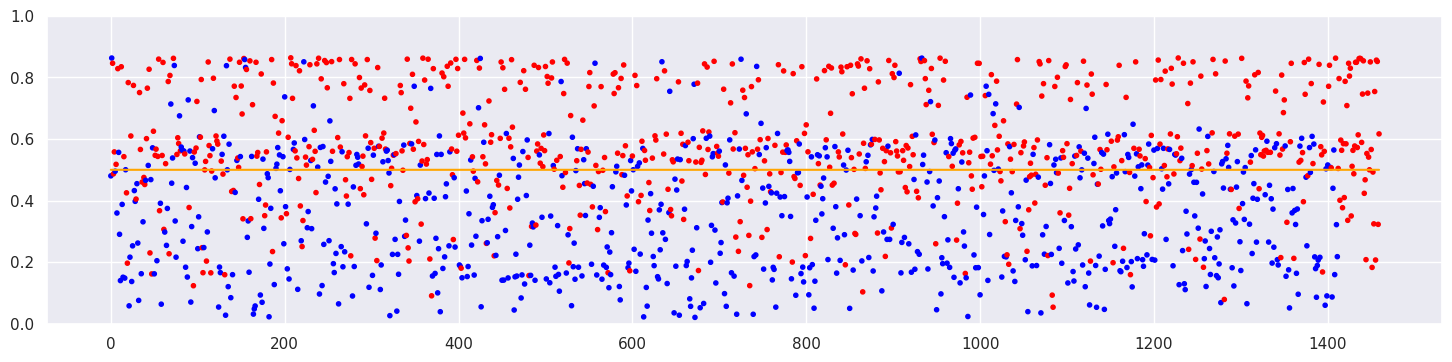

<Figure size 640x480 with 0 Axes>

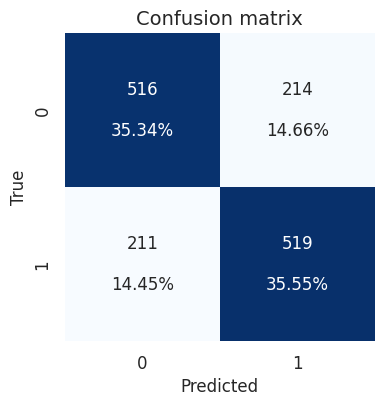

In [319]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=300

#### Create and train model

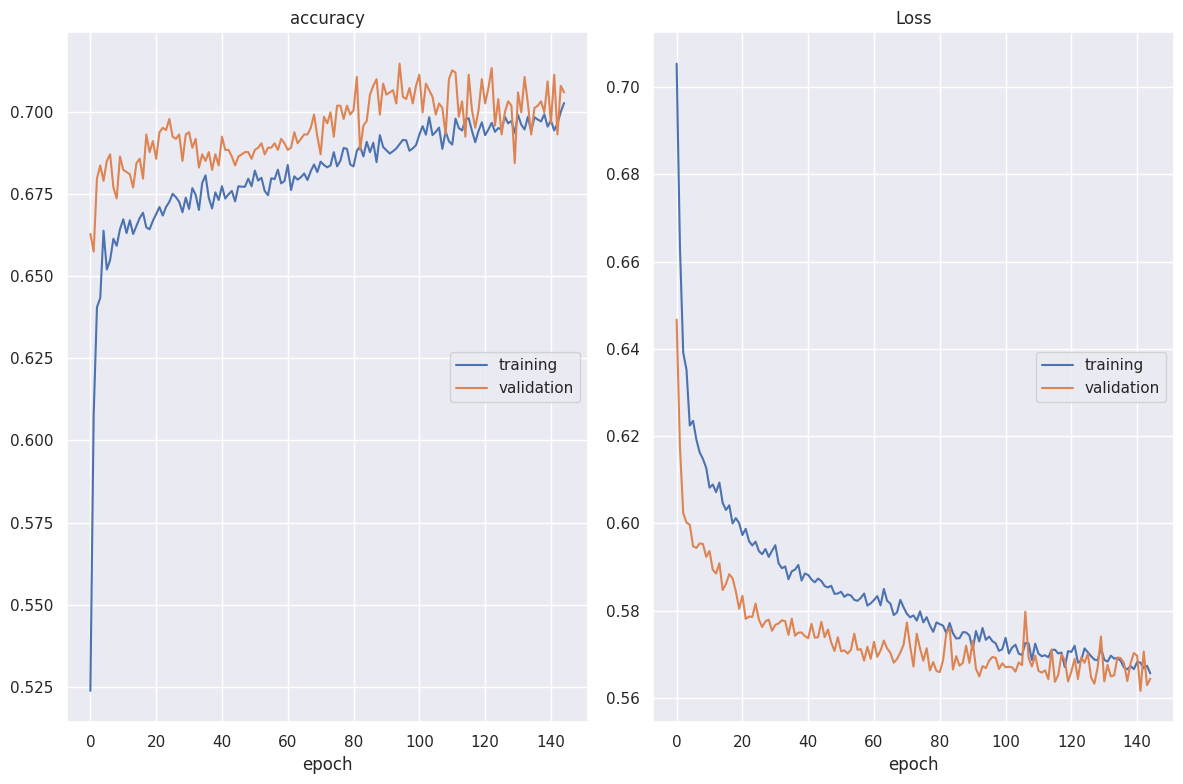

accuracy
	training         	 (min:    0.524, max:    0.703, cur:    0.703)
	validation       	 (min:    0.657, max:    0.715, cur:    0.706)
Loss
	training         	 (min:    0.566, max:    0.705, cur:    0.566)
	validation       	 (min:    0.562, max:    0.647, cur:    0.564)

Epoch 145: val_accuracy did not improve from 0.71467
47/47 [==============================] - 1s 18ms/step - loss: 0.5656 - accuracy: 0.7027 - val_loss: 0.5644 - val_accuracy: 0.7059


In [320]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_150_only_import_feat_standard'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.7006849315068493
Precision: [0.74214876 0.67134503]
Recall: 0.7863013698630137
F1 score: 0.724290
ROC AUC: 0.700685


(0.7006849315068493,
 array([0.74214876, 0.67134503]),
 0.7863013698630137,
 0.7242902208201893,
 0.7006849315068493)

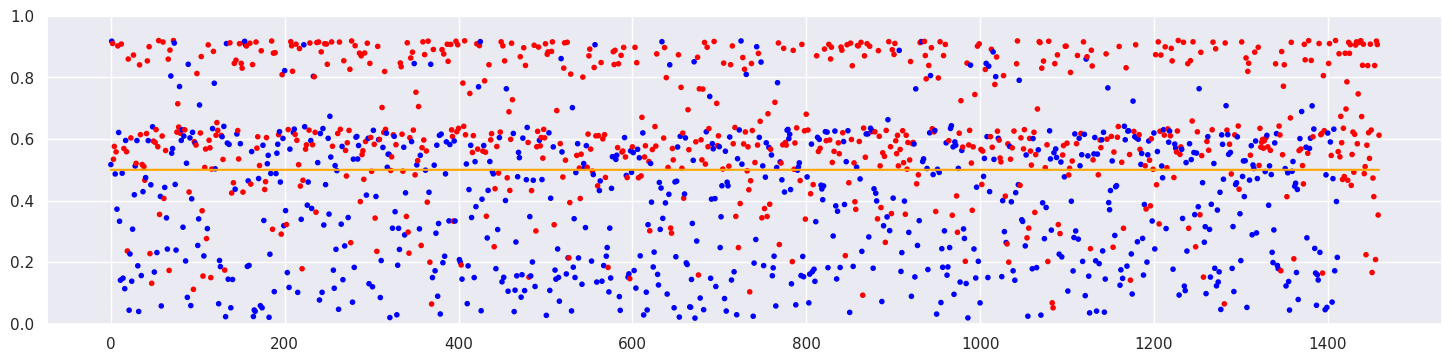

<Figure size 640x480 with 0 Axes>

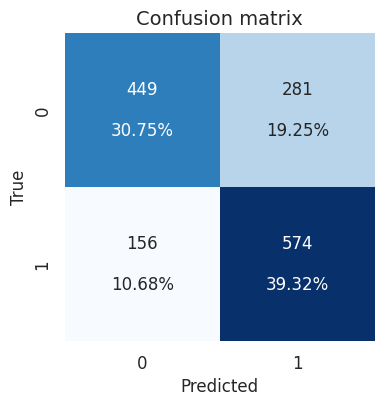

In [321]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=300

#### Create and train model

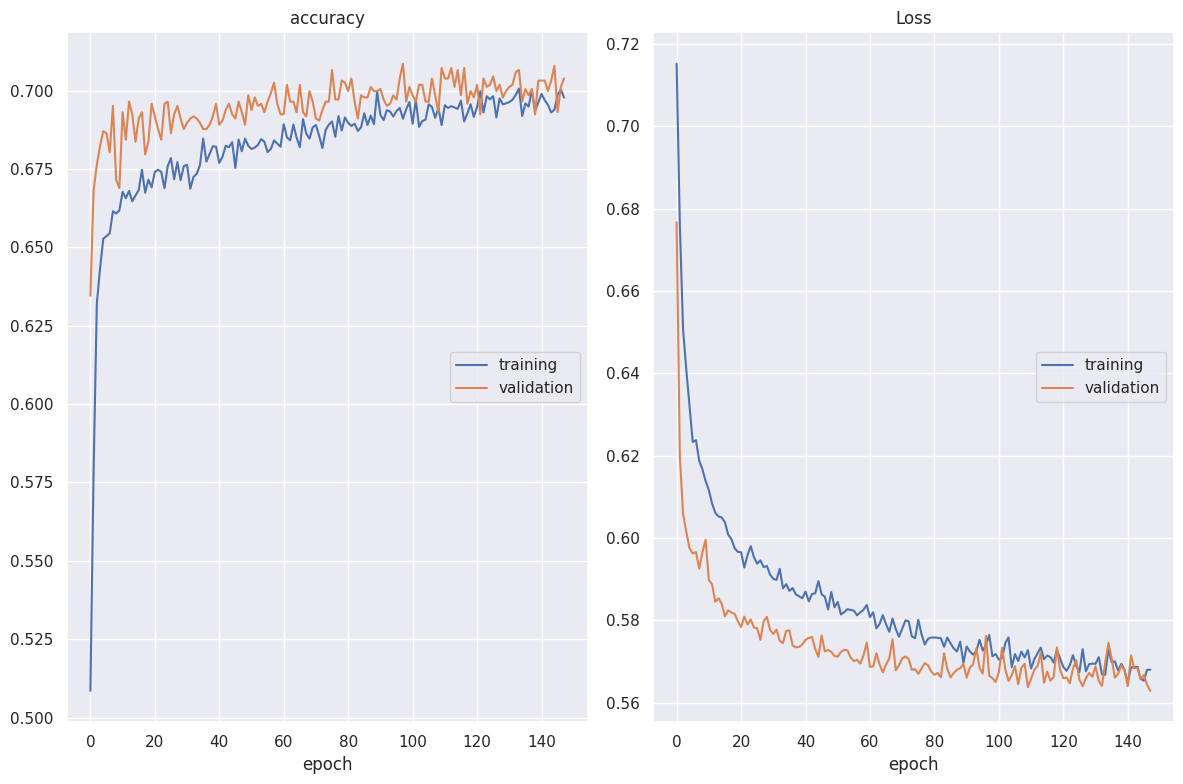

accuracy
	training         	 (min:    0.508, max:    0.701, cur:    0.698)
	validation       	 (min:    0.635, max:    0.709, cur:    0.704)
Loss
	training         	 (min:    0.565, max:    0.715, cur:    0.568)
	validation       	 (min:    0.563, max:    0.677, cur:    0.563)

Epoch 148: val_accuracy did not improve from 0.70861
35/35 [==============================] - 1s 24ms/step - loss: 0.5680 - accuracy: 0.6978 - val_loss: 0.5629 - val_accuracy: 0.7039


In [322]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_200_only_import_feat_standard'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.702054794520548
Precision: [0.71345876 0.69180754]
Recall: 0.7287671232876712
F1 score: 0.709807
ROC AUC: 0.702055


(0.702054794520548,
 array([0.71345876, 0.69180754]),
 0.7287671232876712,
 0.7098065376917945,
 0.7020547945205479)

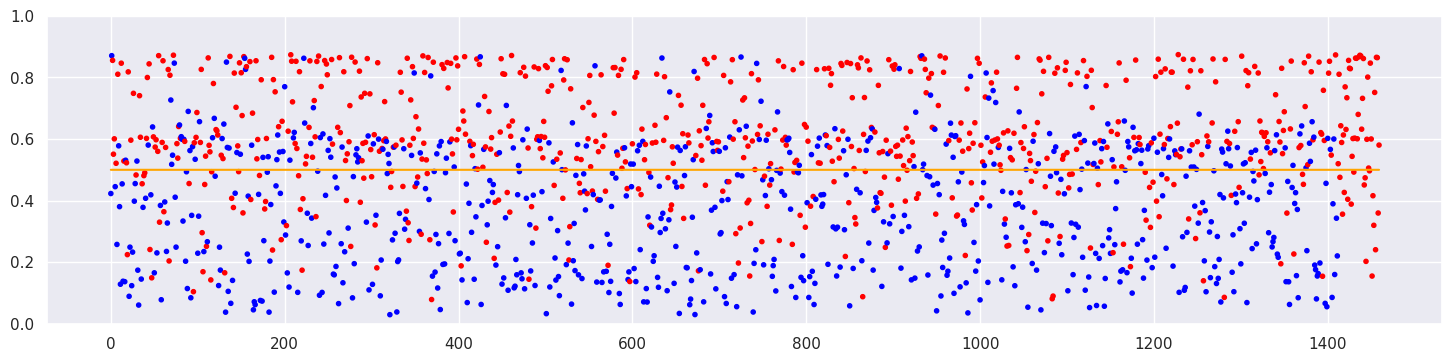

<Figure size 640x480 with 0 Axes>

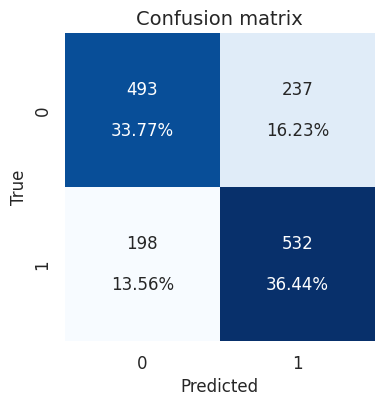

In [323]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=300

#### Create and train model

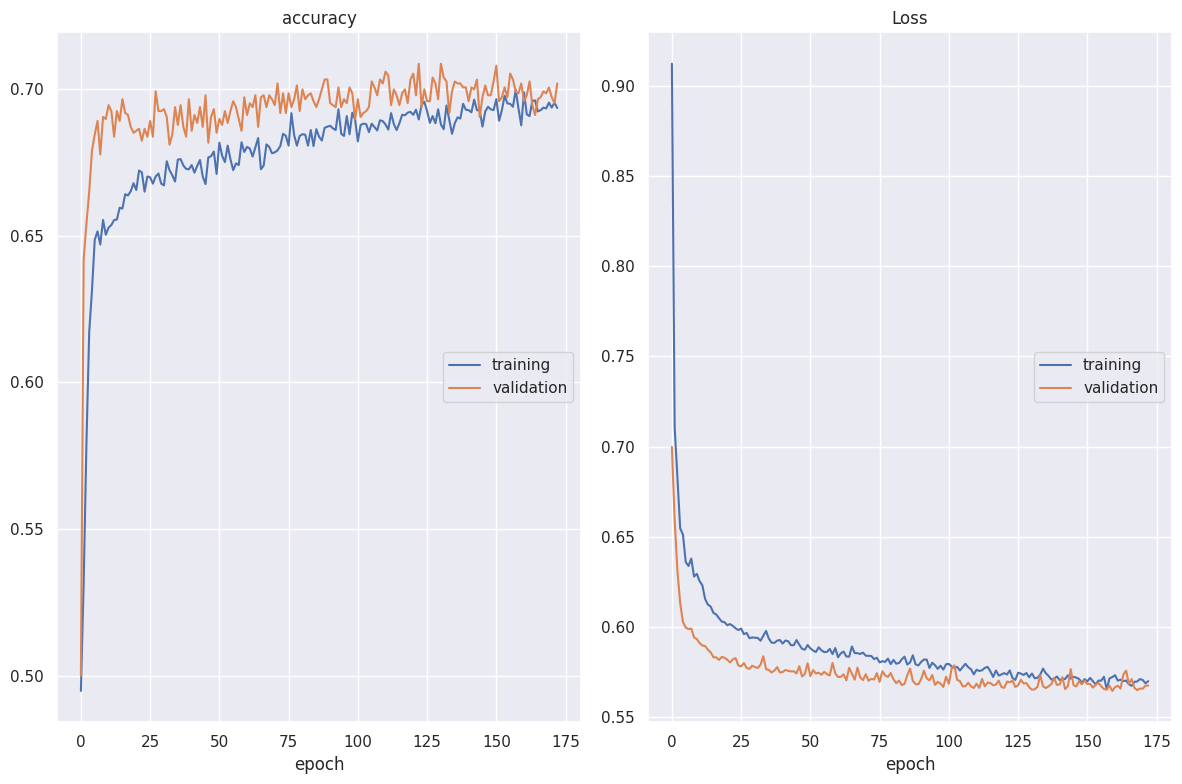

accuracy
	training         	 (min:    0.495, max:    0.700, cur:    0.693)
	validation       	 (min:    0.500, max:    0.709, cur:    0.702)
Loss
	training         	 (min:    0.565, max:    0.912, cur:    0.570)
	validation       	 (min:    0.565, max:    0.700, cur:    0.567)

Epoch 173: val_accuracy did not improve from 0.70861
28/28 [==============================] - 1s 27ms/step - loss: 0.5699 - accuracy: 0.6935 - val_loss: 0.5675 - val_accuracy: 0.7019


In [324]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_250_only_import_feat_standard'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.7041095890410959
Precision: [0.71164773 0.69708995]
Recall: 0.7219178082191781
F1 score: 0.709287
ROC AUC: 0.704110


(0.7041095890410959,
 array([0.71164773, 0.69708995]),
 0.7219178082191781,
 0.7092866756393001,
 0.704109589041096)

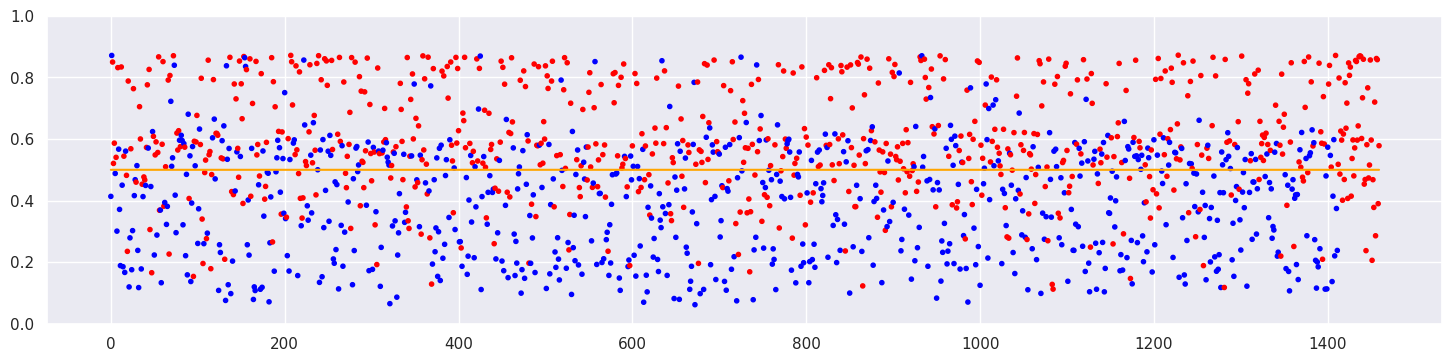

<Figure size 640x480 with 0 Axes>

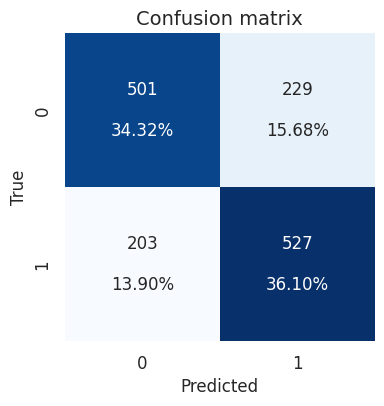

In [325]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=300

#### Create and train model

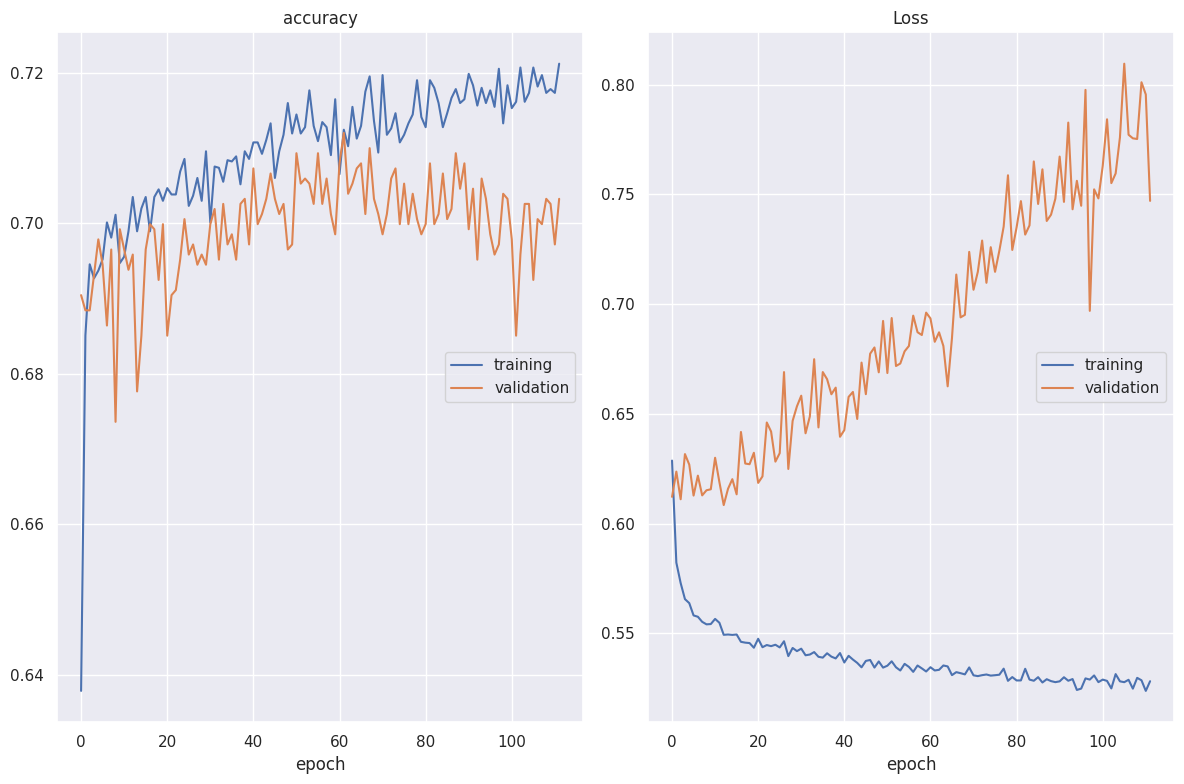

accuracy
	training         	 (min:    0.638, max:    0.721, cur:    0.721)
	validation       	 (min:    0.674, max:    0.712, cur:    0.703)
Loss
	training         	 (min:    0.524, max:    0.629, cur:    0.528)
	validation       	 (min:    0.608, max:    0.810, cur:    0.747)

Epoch 112: val_accuracy did not improve from 0.71198
594/594 [==============================] - 2s 4ms/step - loss: 0.5281 - accuracy: 0.7212 - val_loss: 0.7470 - val_accuracy: 0.7032


In [338]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_10_only_import_feat_standard'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.6986301369863014
Precision: [0.70480226 0.69281915]
Recall: 0.7136986301369863
F1 score: 0.703104
ROC AUC: 0.698630


(0.6986301369863014,
 array([0.70480226, 0.69281915]),
 0.7136986301369863,
 0.7031039136302294,
 0.6986301369863014)

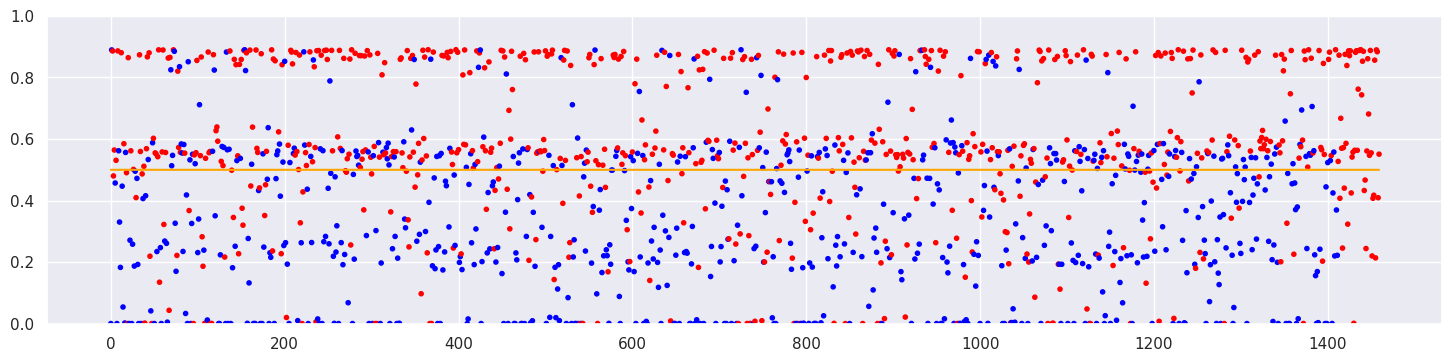

<Figure size 640x480 with 0 Axes>

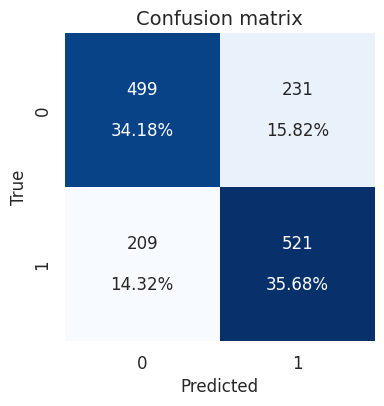

In [339]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=300

#### Create and train model

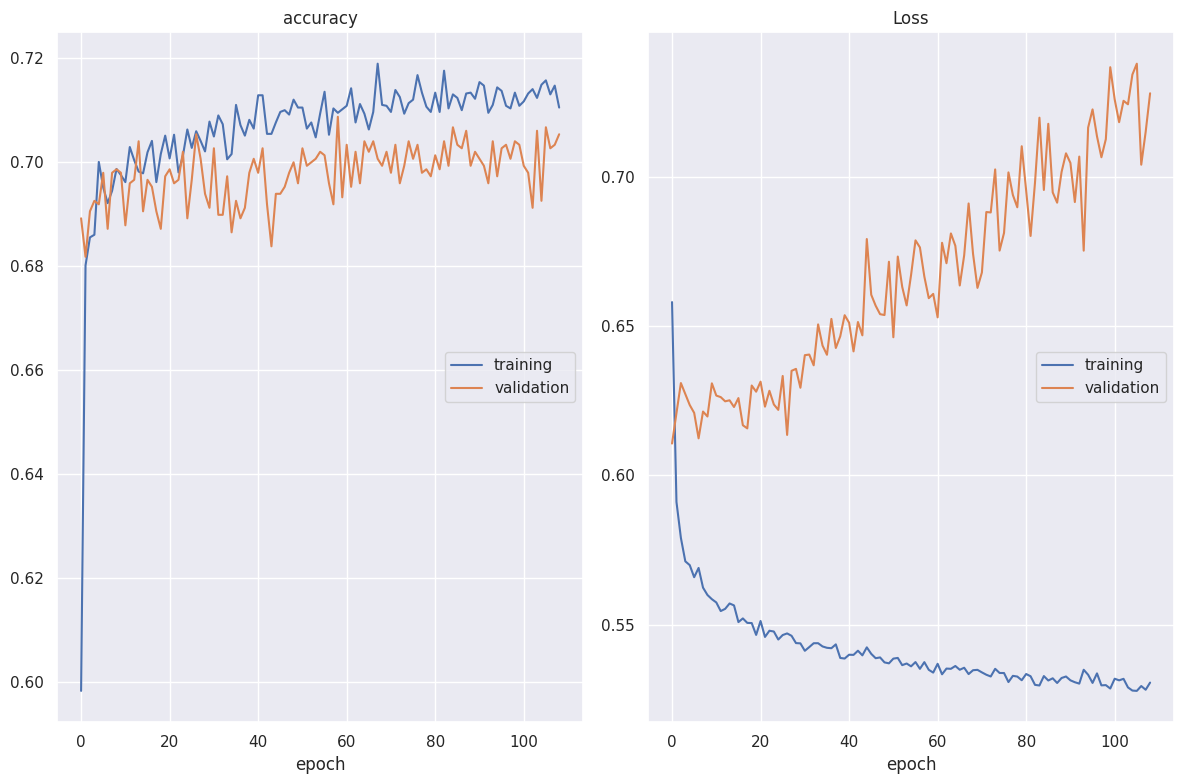

accuracy
	training         	 (min:    0.598, max:    0.719, cur:    0.710)
	validation       	 (min:    0.682, max:    0.709, cur:    0.705)
Loss
	training         	 (min:    0.528, max:    0.658, cur:    0.531)
	validation       	 (min:    0.611, max:    0.738, cur:    0.728)

Epoch 109: val_accuracy did not improve from 0.70861
119/119 [==============================] - 1s 8ms/step - loss: 0.5306 - accuracy: 0.7104 - val_loss: 0.7279 - val_accuracy: 0.7052


In [340]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_50_only_import_feat_standard'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=300)

#### Prediction and results

Accuracy: 0.6952054794520548
Precision: [0.7092511  0.68292683]
Recall: 0.7287671232876712
F1 score: 0.705103
ROC AUC: 0.695205


(0.6952054794520548,
 array([0.7092511 , 0.68292683]),
 0.7287671232876712,
 0.7051027170311465,
 0.6952054794520547)

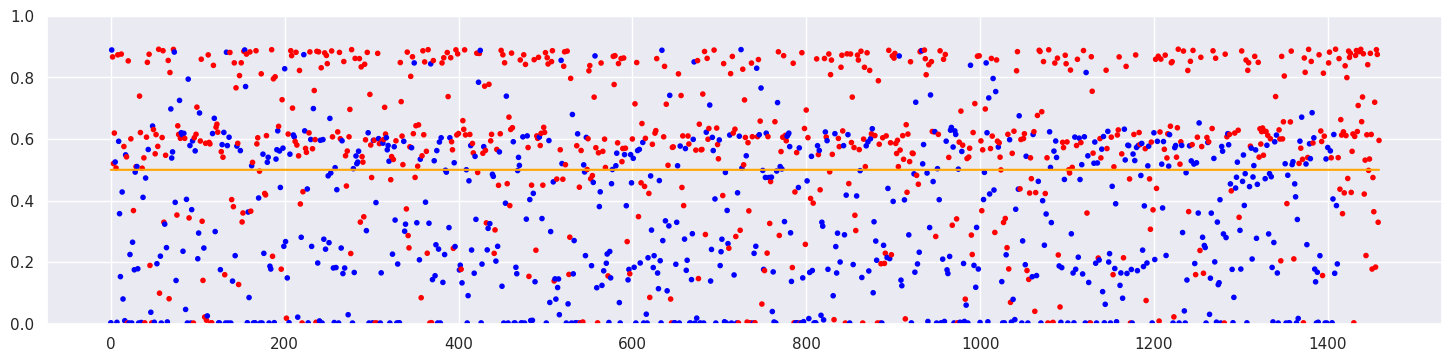

<Figure size 640x480 with 0 Axes>

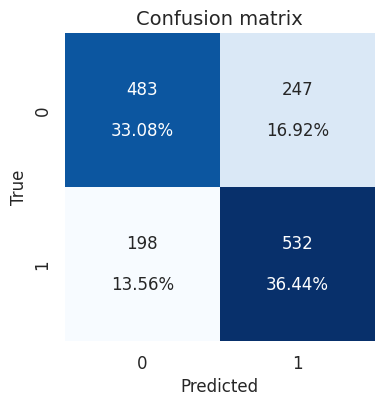

In [341]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=300

#### Create and train model

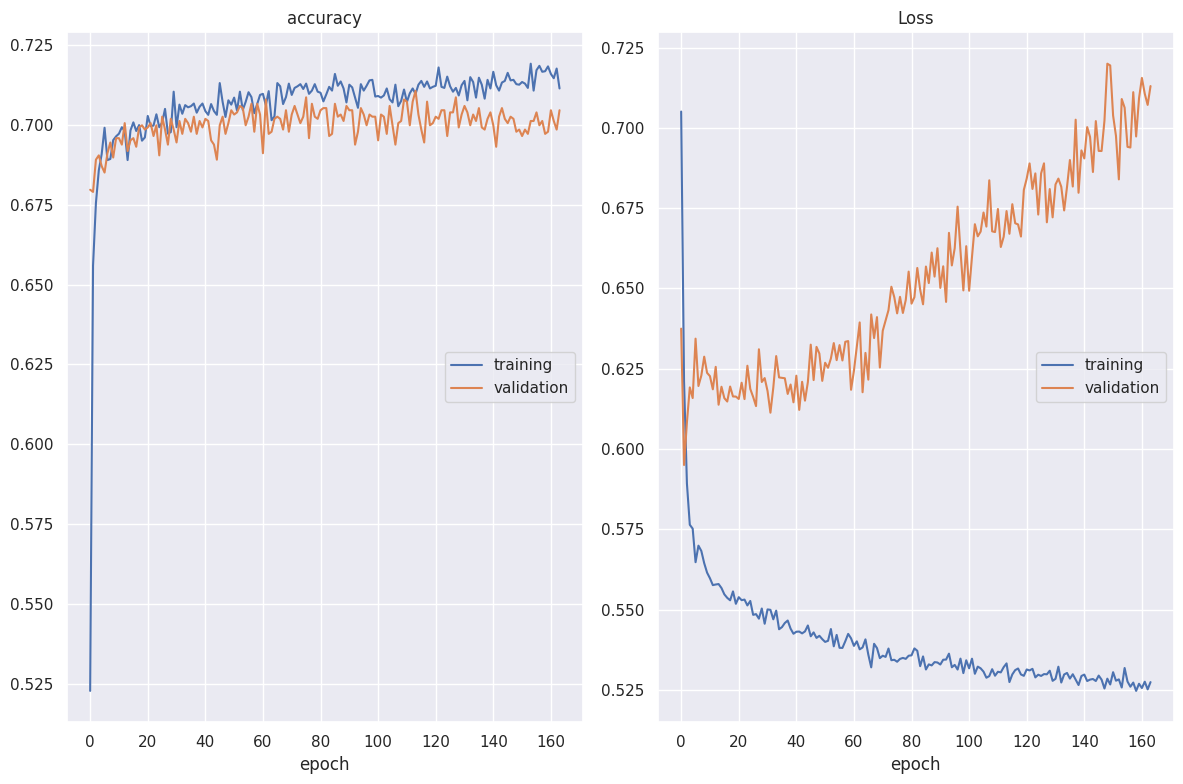

accuracy
	training         	 (min:    0.523, max:    0.719, cur:    0.711)
	validation       	 (min:    0.679, max:    0.711, cur:    0.705)
Loss
	training         	 (min:    0.525, max:    0.705, cur:    0.527)
	validation       	 (min:    0.595, max:    0.720, cur:    0.713)

Epoch 164: val_accuracy did not improve from 0.71063
60/60 [==============================] - 1s 22ms/step - loss: 0.5275 - accuracy: 0.7114 - val_loss: 0.7130 - val_accuracy: 0.7046


In [330]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_100_only_import_feat_standard'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.6938356164383561
Precision: [0.71406959 0.67709637]
Recall: 0.7410958904109589
F1 score: 0.707652
ROC AUC: 0.693836


(0.6938356164383561,
 array([0.71406959, 0.67709637]),
 0.7410958904109589,
 0.7076520601700457,
 0.6938356164383561)

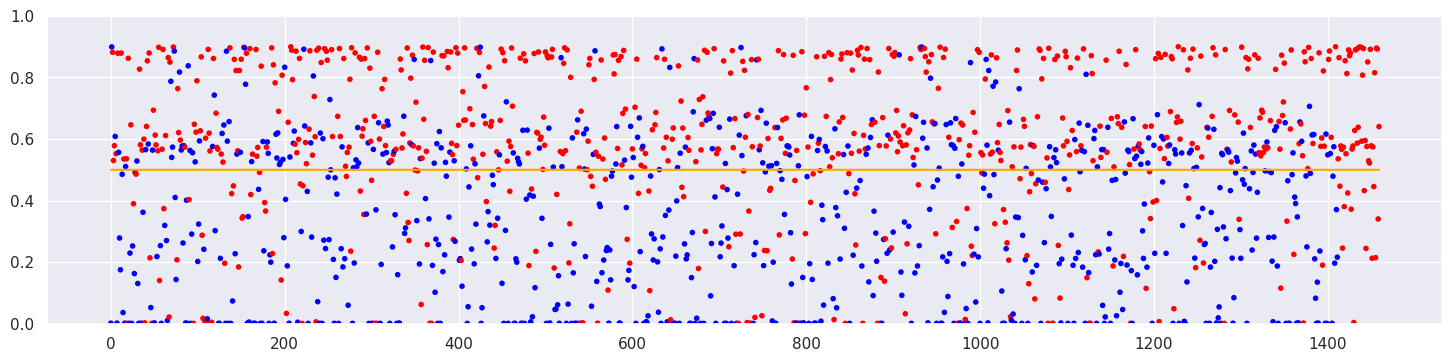

<Figure size 640x480 with 0 Axes>

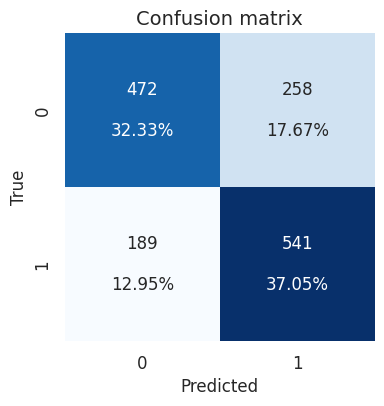

In [331]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=300

#### Create and train model

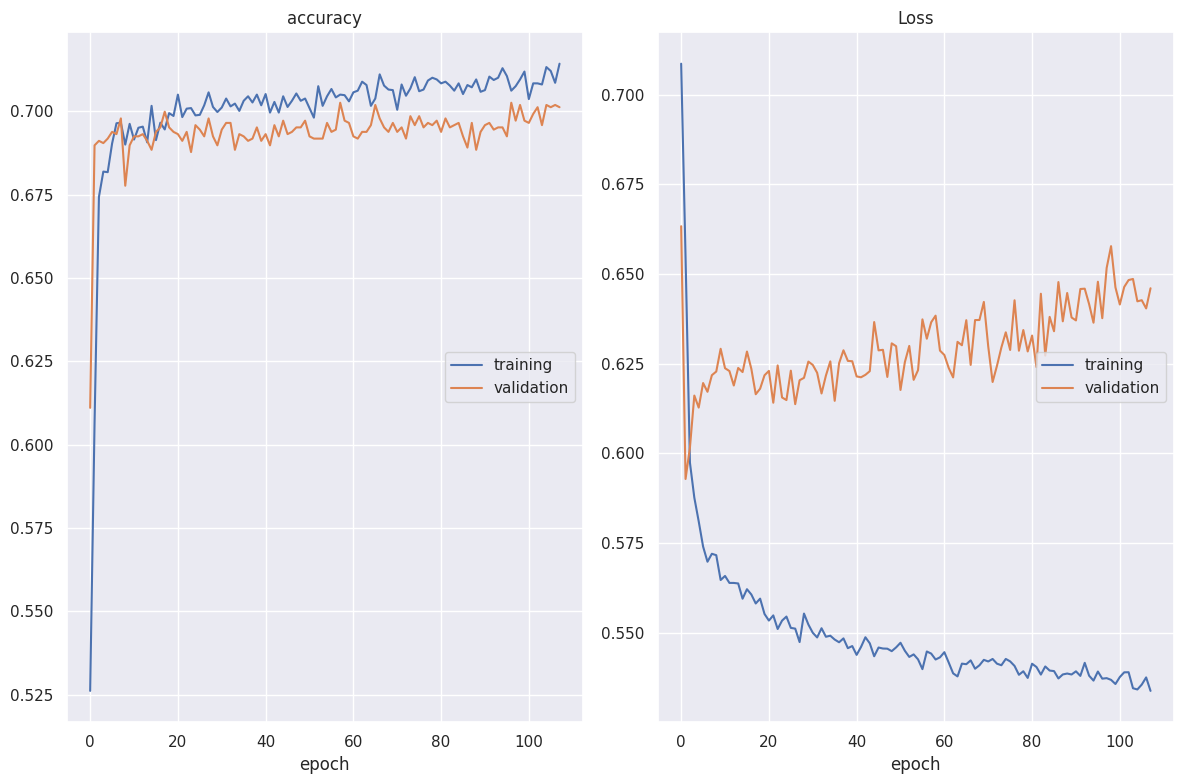

accuracy
	training         	 (min:    0.526, max:    0.714, cur:    0.714)
	validation       	 (min:    0.611, max:    0.703, cur:    0.701)
Loss
	training         	 (min:    0.534, max:    0.709, cur:    0.534)
	validation       	 (min:    0.593, max:    0.663, cur:    0.646)

Epoch 108: val_accuracy did not improve from 0.70256
40/40 [==============================] - 1s 19ms/step - loss: 0.5338 - accuracy: 0.7143 - val_loss: 0.6461 - val_accuracy: 0.7012


In [332]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_150_only_import_feat_standard'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.6910958904109589
Precision: [0.69401947 0.68825911]
Recall: 0.6986301369863014
F1 score: 0.693406
ROC AUC: 0.691096


(0.6910958904109589,
 array([0.69401947, 0.68825911]),
 0.6986301369863014,
 0.6934058463630183,
 0.691095890410959)

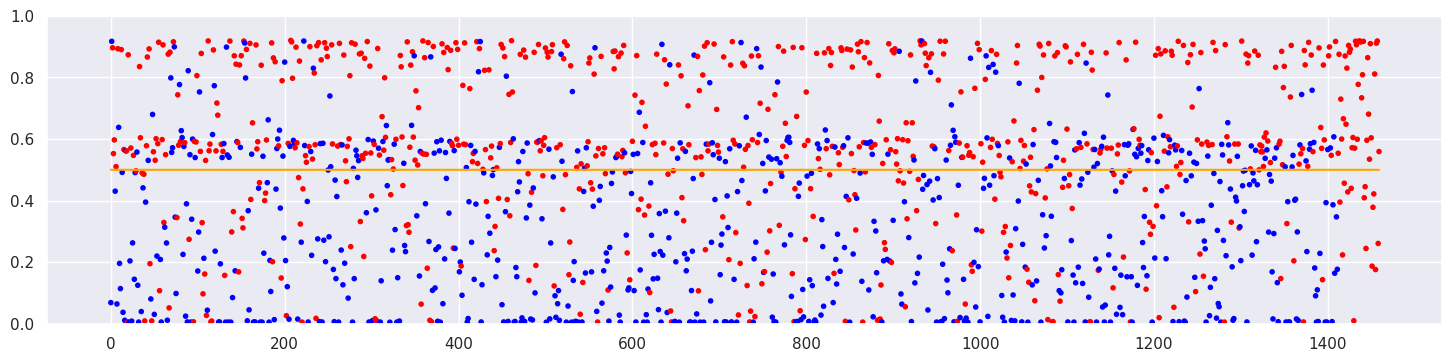

<Figure size 640x480 with 0 Axes>

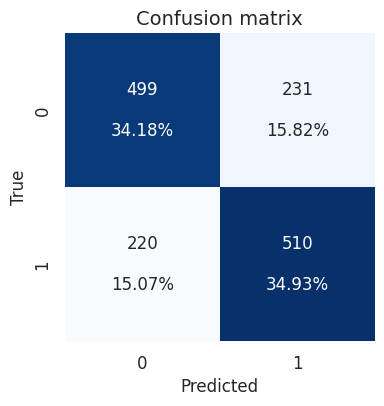

In [333]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=300

#### Create and train model

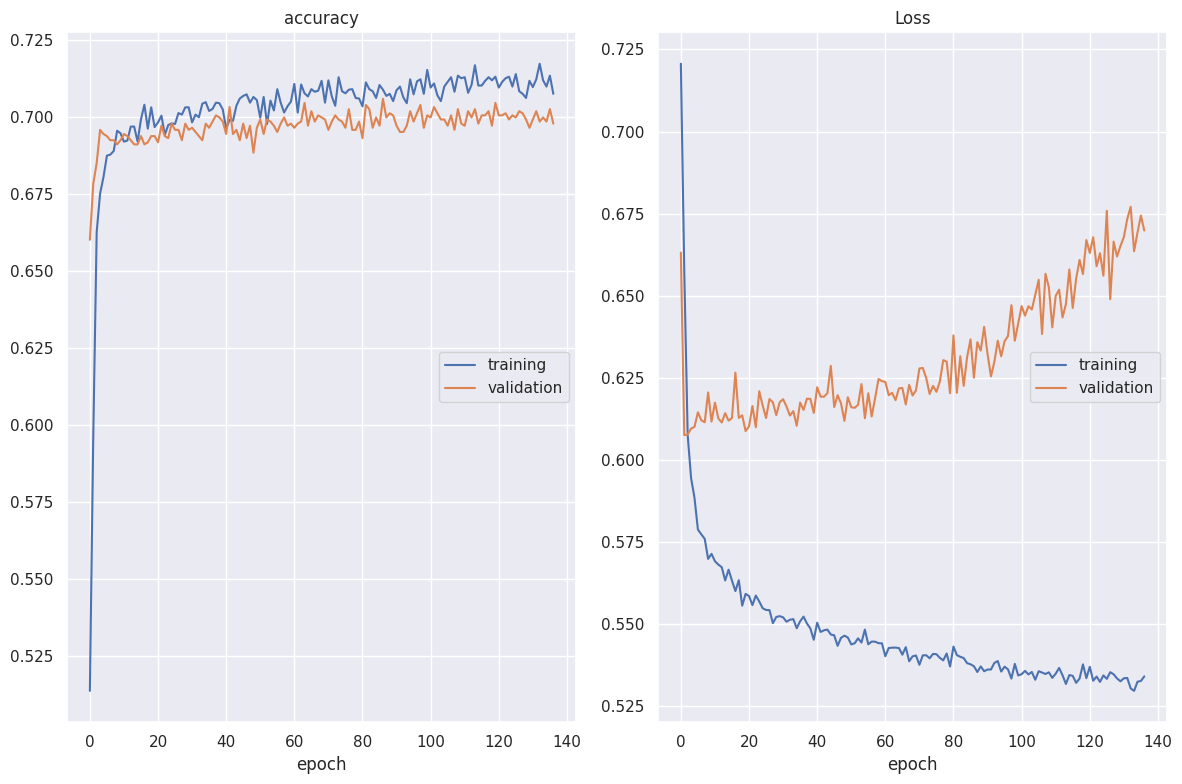

accuracy
	training         	 (min:    0.514, max:    0.717, cur:    0.708)
	validation       	 (min:    0.660, max:    0.706, cur:    0.698)
Loss
	training         	 (min:    0.530, max:    0.721, cur:    0.534)
	validation       	 (min:    0.608, max:    0.677, cur:    0.670)

Epoch 137: val_accuracy did not improve from 0.70592
30/30 [==============================] - 1s 27ms/step - loss: 0.5341 - accuracy: 0.7075 - val_loss: 0.6698 - val_accuracy: 0.6978


In [334]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_200_only_import_feat_standard'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.6917808219178082
Precision: [0.71875    0.67073171]
Recall: 0.7534246575342466
F1 score: 0.709677
ROC AUC: 0.691781


(0.6917808219178082,
 array([0.71875   , 0.67073171]),
 0.7534246575342466,
 0.7096774193548389,
 0.6917808219178083)

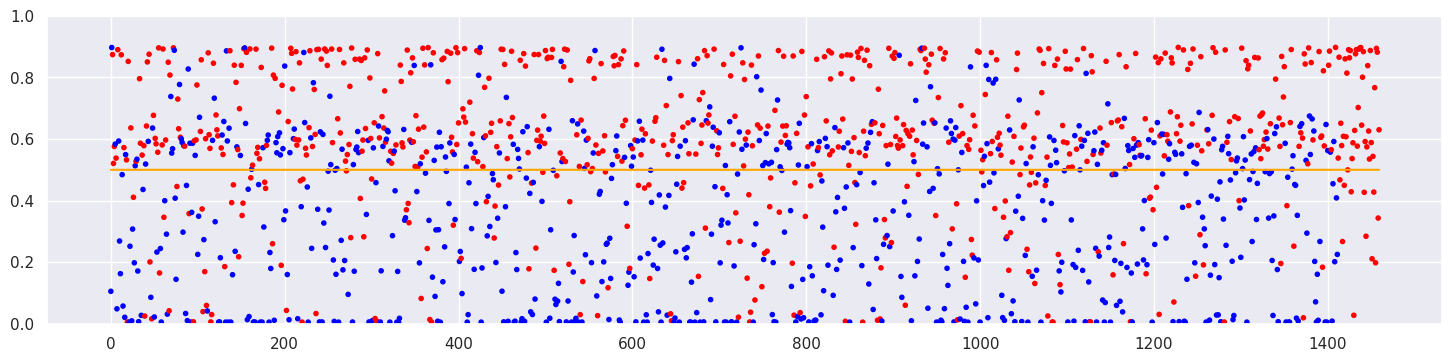

<Figure size 640x480 with 0 Axes>

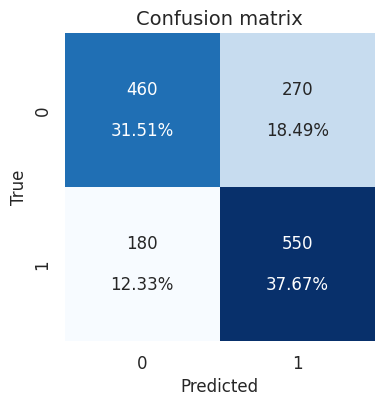

In [335]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=300

#### Create and train model

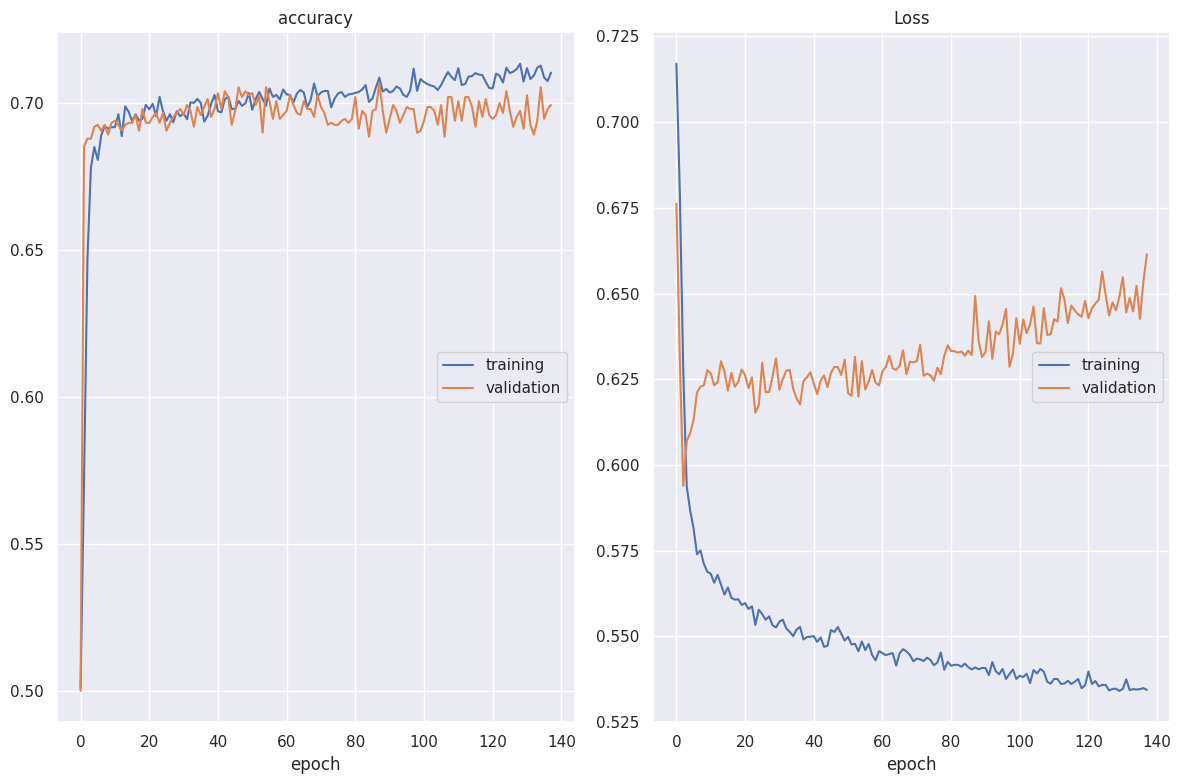

accuracy
	training         	 (min:    0.501, max:    0.713, cur:    0.710)
	validation       	 (min:    0.500, max:    0.707, cur:    0.699)
Loss
	training         	 (min:    0.534, max:    0.717, cur:    0.534)
	validation       	 (min:    0.594, max:    0.676, cur:    0.661)

Epoch 138: val_accuracy did not improve from 0.70659
24/24 [==============================] - 1s 31ms/step - loss: 0.5344 - accuracy: 0.7102 - val_loss: 0.6614 - val_accuracy: 0.6992


In [336]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_250_only_import_feat_standard'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.686986301369863
Precision: [0.69037657 0.68371467]
Recall: 0.6958904109589041
F1 score: 0.689749
ROC AUC: 0.686986


(0.686986301369863,
 array([0.69037657, 0.68371467]),
 0.6958904109589041,
 0.6897488119484046,
 0.686986301369863)

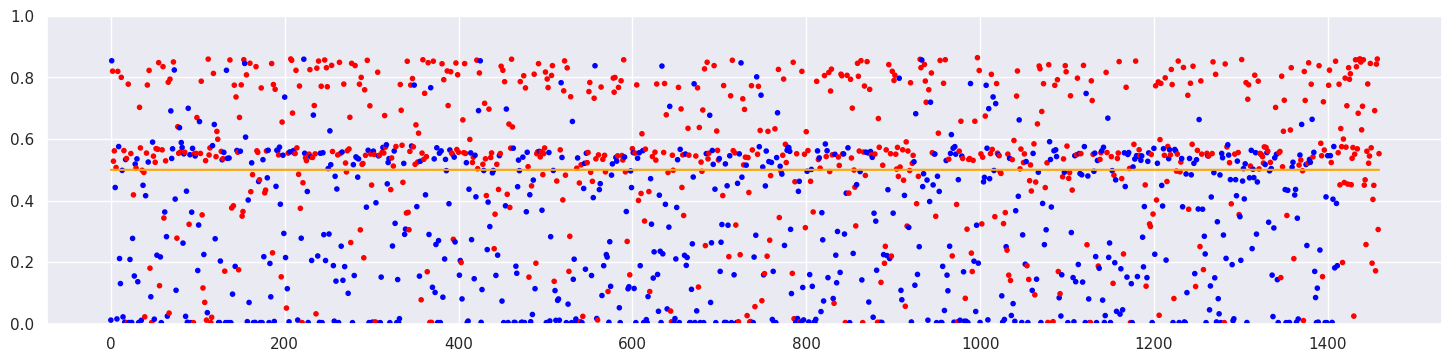

<Figure size 640x480 with 0 Axes>

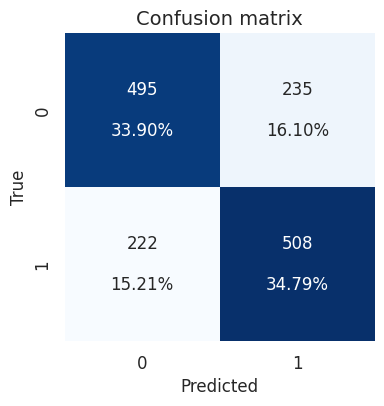

In [337]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)